In [12]:
pip install arch

# Data fiting and parameter estimation algorithm

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing NEM
Fetched data for NEM: 251 records.
Fetched data for NEM: 464 records.
Calculated returns for NEM (Pre-COVID): 250 records.
Calculated returns for NEM (Post-COVID): 463 records.



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetched data for ^GSPC: 251 records.
Fetched data for ^GSPC: 464 records.
Calculated returns for ^GSPC (Pre-COVID): 250 records.
Calculated returns for ^GSPC (Post-COVID): 463 records.
Parameters of the fitted Normal distribution: mean = 0.00123, std = 0.01508
Parameters of the fitted Normal distribution: mean = 0.00100, std = 0.02424
Parameters of the fitted Student-t distribution: df = 5.46121, loc = 0.00181, scale = 0.01189
Parameters of the fitted Student-t distribution: df = 3.25327, loc = 0.00040, scale = 0.01553
Parameters of the fitted GED: beta = 1.29605, loc = 0.00184, scale = 0.01502
Parameters of the fitted GED: beta = 0.99722, loc = -0.00016, scale = 0.01650
Parameters of the fitted Skewed Normal distribution: alpha = -1.70665, loc = 0.01520, scale = 0.02056
Parameters of the fitted Skewed Normal distribution: alpha = 1.14748, loc = -0.01687, scale = 0.03011

Analysis for NEM
Under Normal Distribution Assumption:
Pre-COVID Mean Return: 0.00123
Pre-COVID Volatility: 0.01511

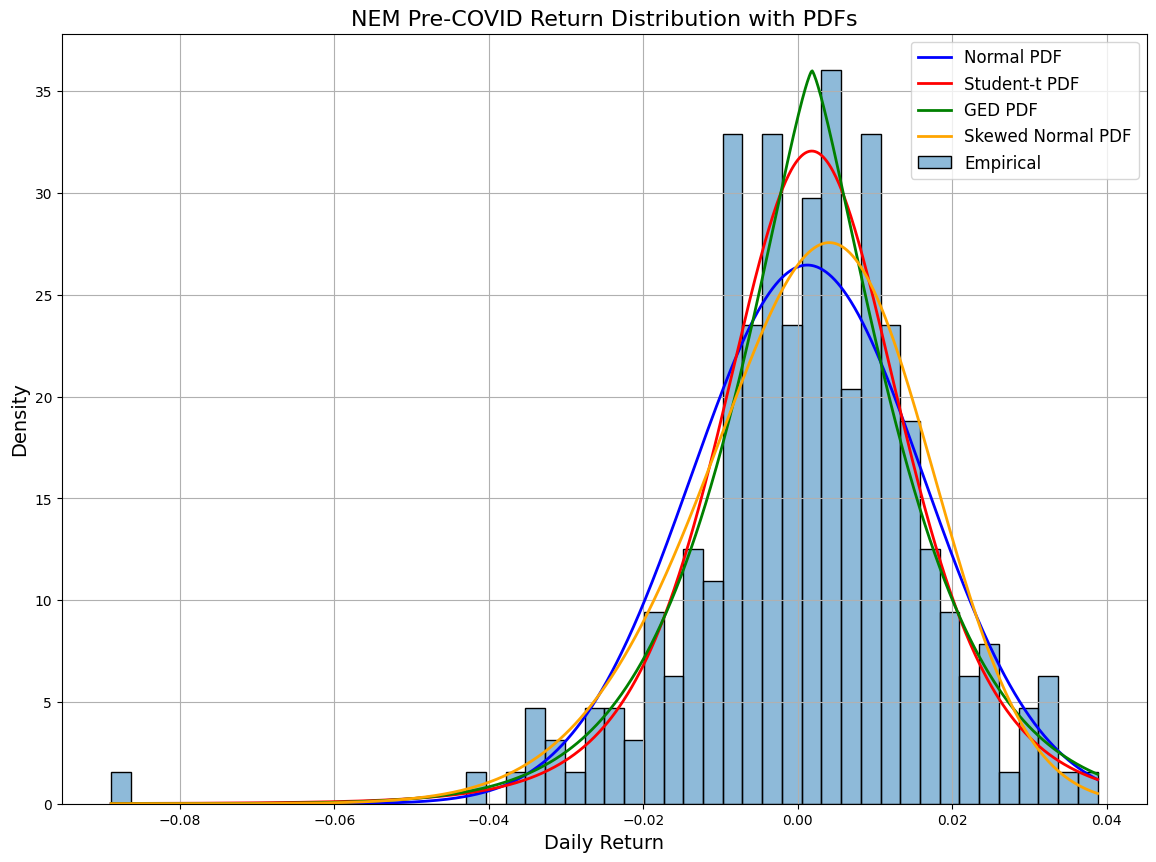

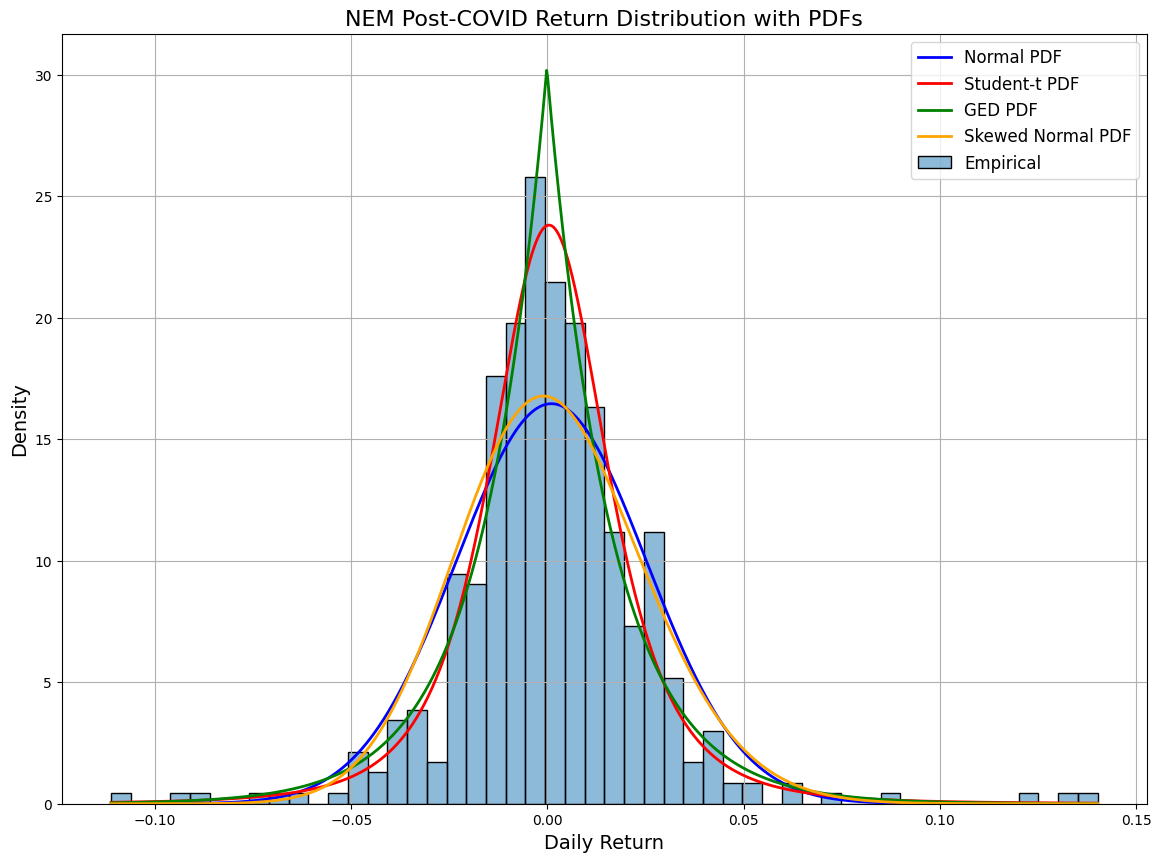

Fitted GARCH(1,1) model for NEM (Pre-COVID) with Normal distribution. AIC: 910.77, BIC: 921.33
Fitted GARCH(1,1) model for NEM (Pre-COVID) with T distribution. AIC: 904.32, BIC: 918.40
Fitted GARCH(1,1) model for NEM (Pre-COVID) with Skewed Student-t. AIC: 901.99, BIC: 919.60
Fitted GARCH(1,1) model for NEM (Pre-COVID) with GED. AIC: 905.56, BIC: 919.64

Model Selection Interpretation for NEM (Pre-COVID):

AIC Interpretation:
Skewt: Delta AIC = 0.00 - Essentially equivalent
T: Delta AIC = 2.32 - No significant difference
Ged: Delta AIC = 3.56 - No significant difference
Normal: Delta AIC = 8.77 - No significant difference

BIC Interpretation:
T: Delta BIC = 0.00 - Weak evidence against this model
Skewt: Delta BIC = 1.20 - Weak evidence against this model
Ged: Delta BIC = 1.24 - Weak evidence against this model
Normal: Delta BIC = 2.93 - Positive evidence against this model

Best Model based on AIC: Skewt Distribution
Best Model based on BIC: T Distribution

Fitted GARCH(1,1) model for 

In [13]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import norm, t, skewnorm, gennorm, kstest, jarque_bera, entropy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from arch import arch_model

# -----------------------------
# 1. Configuration Parameters
# -----------------------------

# Define the stocks and benchmark to analyze
stocks = ['NEM']
benchmark = '^GSPC'  # S&P 500

# Define the time periods
pre_covid_start = '2019-01-01'
pre_covid_end = '2019-12-31'
post_covid_start = '2020-03-01'
post_covid_end = '2021-12-31'

# -----------------------------
# 2. Data Acquisition Functions
# -----------------------------

def fetch_data(symbol, start_date, end_date):
    """
    Fetches historical adjusted closing prices for a given symbol between start_date and end_date.
    """
    data = yf.download(symbol, start=start_date, end=end_date)['Close']
    if data.empty:
        print(f'No data fetched for {symbol}.')
        return None
    print(f'Fetched data for {symbol}: {len(data)} records.')
    return data

def calculate_returns(data, symbol, period):
    """
    Calculates daily percentage returns from adjusted closing prices.
    """
    if data is None:
        print(f'No data to calculate returns for {symbol} ({period}).')
        return None
    returns = data.pct_change().dropna()
    print(f'Calculated returns for {symbol} ({period}): {len(returns)} records.')
    return returns

# -----------------------------
# 3. Distribution Metrics
# -----------------------------

def calculate_normal_metrics(returns):
    """
    Calculates mean return, volatility, and Value at Risk (VaR) under normal distribution assumption.
    Ensures that all returned values are scalars.
    """
    mean_return = float(returns.mean().iloc[0])
    volatility = float(returns.std().iloc[0])
    VaR_95 = float(returns.quantile(0.05).iloc[0])  # 5% VaR
    return mean_return, volatility, VaR_95

def calculate_heavy_tail_metrics(returns):
    """
    Calculates skewness, kurtosis, and Conditional Value at Risk (CVaR) under heavy-tailed distribution assumption.
    Ensures that all returned values are scalars.
    """
    skewness = float(returns.skew().iloc[0])
    kurt = float(returns.kurtosis().iloc[0])
    VaR_95 = float(returns.quantile(0.05).iloc[0])
    CVaR_95 = float(returns[returns <= VaR_95].mean().iloc[0])  # CVaR
    return skewness, kurt, CVaR_95

def is_heavy_tailed(kurt):
    """
    Determines if a distribution is heavy-tailed based on kurtosis.
    """
    return kurt > 3

# -----------------------------
# 4. Goodness-of-Fit Tests
# -----------------------------

def goodness_of_fit_tests(returns, dist_name):
    """
    Performs goodness-of-fit tests (K-S test) and calculates AIC and BIC for a specified distribution.

    Parameters:
    - returns (pd.Series): Return series.
    - dist_name (str): Name of the distribution ('normal', 'students_t', 'ged', 'skewnorm').

    Returns:
    - dict: Dictionary containing parameters, K-S statistic, p-value, log-likelihood, AIC, and BIC.
    """
    n = len(returns)
    if dist_name == 'normal':
        params = norm.fit(returns)  # Estimates mean and std
        mean, std = params
        mean = float(mean)
        std = float(std)
        print(f"Parameters of the fitted Normal distribution: mean = {mean:.5f}, std = {std:.5f}")
        D, p_value = kstest(returns, 'norm', args=(mean, std))
        log_likelihood = np.sum(norm.logpdf(returns, mean, std))
        k_param = 2  # mean and std
    elif dist_name == 'students_t':
        params = t.fit(returns)  # Estimates df, loc, scale
        df, loc, scale = params
        df = float(df)
        loc = float(loc)
        scale = float(scale)
        print(f"Parameters of the fitted Student-t distribution: df = {df:.5f}, loc = {loc:.5f}, scale = {scale:.5f}")
        D, p_value = kstest(returns, 't', args=(df, loc, scale))
        log_likelihood = np.sum(t.logpdf(returns, df, loc, scale))
        k_param = 3  # df, loc, scale
    elif dist_name == 'skewnorm':
        # Skewed Normal Distribution
        params = skewnorm.fit(returns)  # Estimates shape, loc, scale
        alpha, loc, scale = params
        alpha = float(alpha)
        loc = float(loc)
        scale = float(scale)
        print(f"Parameters of the fitted Skewed Normal distribution: alpha = {alpha:.5f}, loc = {loc:.5f}, scale = {scale:.5f}")
        D, p_value = kstest(returns, 'skewnorm', args=(alpha, loc, scale))
        log_likelihood = np.sum(skewnorm.logpdf(returns, alpha, loc, scale))
        k_param = 3  # alpha, loc, scale
    elif dist_name == 'ged':
        # Generalized Error Distribution using gennorm
        params = gennorm.fit(returns)  # Estimates shape (beta), loc, scale
        beta, loc, scale = params
        beta = float(beta)
        loc = float(loc)
        scale = float(scale)
        print(f"Parameters of the fitted GED: beta = {beta:.5f}, loc = {loc:.5f}, scale = {scale:.5f}")
        D, p_value = kstest(returns, 'gennorm', args=(beta, loc, scale))
        log_likelihood = np.sum(gennorm.logpdf(returns, beta, loc, scale))
        k_param = 3  # beta, loc, scale
    else:
        print(f"Unsupported distribution: {dist_name}")
        return None

    # Calculate AIC and BIC
    aic = 2 * k_param - 2 * log_likelihood
    bic = k_param * np.log(n) - 2 * log_likelihood

    return {
        'params': params,  # Tuple of parameters
        'K-S Statistic': float(D),
        'K-S p-value': float(p_value),
        'Log-Likelihood': float(log_likelihood),
        'AIC': float(aic),
        'BIC': float(bic)
    }

# -----------------------------
# 5. Visualization Functions
# -----------------------------

def plot_histogram_with_pdfs(returns, params_normal, params_t, params_ged, params_skewnorm, title):
    """
    Plots histogram of returns with fitted Normal, Student-t, GED, and Skewed Normal PDFs.

    Parameters:
    - returns (pd.Series): Return series.
    - params_normal (tuple): Parameters for Normal distribution.
    - params_t (tuple): Parameters for Student-t distribution.
    - params_ged (tuple): Parameters for GED distribution.
    - params_skewnorm (tuple): Parameters for Skewed Normal distribution.
    - title (str): Title of the plot.
    """
    plt.figure(figsize=(14, 10))
    sns.histplot(returns, bins=50, kde=False, stat='density', label='Empirical', color='lightgray', edgecolor='black')

    x = np.linspace(returns.min(), returns.max(), 1000)

    # Normal PDF
    mean, std = params_normal
    plt.plot(x, norm.pdf(x, mean, std), label='Normal PDF', color='blue', lw=2)

    # Student-t PDF
    df, loc, scale = params_t
    plt.plot(x, t.pdf(x, df, loc, scale), label='Student-t PDF', color='red', lw=2)

    # GED PDF
    beta, loc, scale = params_ged
    plt.plot(x, gennorm.pdf(x, beta, loc=loc, scale=scale), label='GED PDF', color='green', lw=2)

    # Skewed Normal PDF
    alpha, loc, scale = params_skewnorm
    plt.plot(x, skewnorm.pdf(x, alpha, loc=loc, scale=scale), label='Skewed Normal PDF', color='orange', lw=2)

    plt.title(title, fontsize=16)
    plt.xlabel('Daily Return', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# -----------------------------
# 6. Predictive Performance (Updated)
# -----------------------------

def predictive_performance(returns):
    """
    Assesses predictive performance by splitting data into train and test sets and calculating MSE.

    Parameters:
    - returns (pd.Series): Return series.

    Returns:
    - tuple: MSEs and fitted parameters for various distributions.
    """
    # Split data into train and test sets (80% train, 20% test)
    split_index = int(len(returns) * 0.8)
    train_returns = returns[:split_index]
    test_returns = returns[split_index:]

    # Fit models on training data
    params_normal = norm.fit(train_returns)
    params_t = t.fit(train_returns)
    params_ged = gennorm.fit(train_returns)
    params_skewnorm = skewnorm.fit(train_returns)

    # Predict on test data
    normal_predictions = np.full(len(test_returns), float(params_normal[0]))
    t_predictions = np.full(len(test_returns), float(params_t[1]))  # loc parameter for t-distribution
    ged_predictions = np.full(len(test_returns), float(params_ged[1]))  # loc parameter for GED
    skewnorm_predictions = np.full(len(test_returns), float(params_skewnorm[1]))  # loc parameter for Skewed Normal

    # Calculate MSEs
    mse_normal = mean_squared_error(test_returns, normal_predictions)
    mse_t = mean_squared_error(test_returns, t_predictions)
    mse_ged = mean_squared_error(test_returns, ged_predictions)
    mse_skewnorm = mean_squared_error(test_returns, skewnorm_predictions)

    return (
        mse_normal, mse_t, mse_ged, mse_skewnorm,
        params_normal, params_t,
        params_ged, params_skewnorm,
        test_returns
    )

# -----------------------------
# 7. Volatility Modeling with GARCH (Updated)
# -----------------------------

def interpret_aic_bic(aic_values, bic_values):
    """
    Interprets AIC and BIC differences to determine the strength of evidence favoring each model.

    Parameters:
    - aic_values (dict): Dictionary of AIC values for each model.
    - bic_values (dict): Dictionary of BIC values for each model.

    Returns:
    - dict: Dictionary containing interpretations for AIC and BIC.
    """
    interpretation = {'AIC': {}, 'BIC': {}}

    # Sort models by AIC and BIC
    sorted_aic = sorted(aic_values.items(), key=lambda x: x[1])
    sorted_bic = sorted(bic_values.items(), key=lambda x: x[1])

    # Calculate delta AIC
    min_aic = sorted_aic[0][1]
    for model, aic in sorted_aic:
        delta = aic - min_aic
        if delta < 2:
            strength = 'Essentially equivalent'
        elif 4 <= delta < 7:
            strength = 'Considerable evidence against this model'
        elif delta >= 10:
            strength = 'Strong evidence against this model'
        else:
            strength = 'No significant difference'
        interpretation['AIC'][model] = {'Delta AIC': delta, 'Strength': strength}

    # Calculate delta BIC
    min_bic = sorted_bic[0][1]
    for model, bic in sorted_bic:
        delta = bic - min_bic
        if delta < 2:
            strength = 'Weak evidence against this model'
        elif 2 <= delta < 6:
            strength = 'Positive evidence against this model'
        elif delta >= 6:
            strength = 'Strong evidence against this model'
        else:
            strength = 'No significant difference'
        interpretation['BIC'][model] = {'Delta BIC': delta, 'Strength': strength}

    return interpretation

def garch_modeling_updated(returns, symbol, period='Pre-COVID'):
    """
    Fits multiple GARCH(1,1) models with different error distributions to the returns
    and selects the best model based on AIC and BIC, including interpretation of differences.
    Includes Normal, Student-t, Skewed Student-t, and GED distributions.

    Parameters:
    - returns (pd.Series): Return series.
    - symbol (str): Stock symbol.
    - period (str): Period label (e.g., 'Pre-COVID').

    Returns:
    - dict: Dictionary containing all fitted models, AIC/BIC values, interpretations, and best models.
    """
    # Correct distribution names as per 'arch' library's expectations
    distributions = ['normal', 't', 'skewt', 'ged']
    model_results = {}
    aic_values = {}
    bic_values = {}
    beta_values = {}

    for dist in distributions:
        model = arch_model(
            returns * 100,
            mean='Zero',          # Explicitly set the mean model to zero
            vol='Garch',
            p=1,
            q=1,
            dist=dist,
            rescale=False
        )
        try:
            # Let the arch library handle starting values automatically
            res = model.fit(disp='off')  # No starting_values parameter
        except Exception as e:
            print(f"Error fitting GARCH model for {symbol} ({period}) with {dist.capitalize()} distribution: {e}")
            continue

        # Store the results
        model_results[dist] = res
        aic_values[dist] = float(res.aic)
        bic_values[dist] = float(res.bic)

        # Extract parameters based on distribution
        if dist == 'ged':
            beta = float(res.params.get('shape', np.nan))
            beta_values[dist] = beta
            print(f"Fitted GARCH(1,1) model for {symbol} ({period}) with GED. AIC: {res.aic:.2f}, BIC: {res.bic:.2f}")
        elif dist == 'skewt':
            shape = float(res.params.get('shape', np.nan))
            skew = float(res.params.get('skew', np.nan))
            print(f"Fitted GARCH(1,1) model for {symbol} ({period}) with Skewed Student-t. AIC: {res.aic:.2f}, BIC: {res.bic:.2f}")
        else:
            print(f"Fitted GARCH(1,1) model for {symbol} ({period}) with {dist.capitalize()} distribution. AIC: {res.aic:.2f}, BIC: {res.bic:.2f}")

    if not aic_values:
        print(f"No successful GARCH models fitted for {symbol} ({period}).")
        return None

    # Interpret AIC and BIC differences
    interpretation = interpret_aic_bic(aic_values, bic_values)

    # Display interpretations
    print(f"\nModel Selection Interpretation for {symbol} ({period}):")
    print("\nAIC Interpretation:")
    for model_name, details in interpretation['AIC'].items():
        print(f"{model_name.capitalize()}: Delta AIC = {details['Delta AIC']:.2f} - {details['Strength']}")

    print("\nBIC Interpretation:")
    for model_name, details in interpretation['BIC'].items():
        print(f"{model_name.capitalize()}: Delta BIC = {details['Delta BIC']:.2f} - {details['Strength']}")

    # Identify best models based on AIC and BIC
    if aic_values:
        best_aic_model = min(aic_values, key=aic_values.get)
        print(f"\nBest Model based on AIC: {best_aic_model.capitalize()} Distribution")
    else:
        best_aic_model = None
        print("\nNo AIC values available to determine the best model.")

    if bic_values:
        best_bic_model = min(bic_values, key=bic_values.get)
        print(f"Best Model based on BIC: {best_bic_model.capitalize()} Distribution\n")
    else:
        best_bic_model = None
        print("No BIC values available to determine the best model.\n")

    return {
        'models': model_results,
        'aic_values': aic_values,
        'bic_values': bic_values,
        'interpretation': interpretation,
        'best_aic_model': model_results[best_aic_model] if best_aic_model else None,
        'best_bic_model': model_results[best_bic_model] if best_bic_model else None
    }

# -----------------------------
# 8. Skewness and Kurtosis Significance Tests
# -----------------------------

def skew_kurtosis_tests(returns, symbol, period='Pre-COVID'):
    """
    Performs the Jarque-Bera test to assess normality of skewness and kurtosis.

    Parameters:
    - returns (pd.Series): Return series.
    - symbol (str): Stock symbol.
    - period (str): Period label (e.g., 'Pre-COVID').
    """
    jb_test = jarque_bera(returns)
    jb_stat = float(jb_test[0])
    jb_p_value = float(jb_test[1])
    print(f"Jarque-Bera Test for {symbol} ({period}):")
    print(f"JB Statistic: {jb_stat:.4f}, p-value: {jb_p_value:.4f}")
    if jb_p_value < 0.05:
        print("Result: Significant deviation from normality.\n")
    else:
        print("Result: No significant deviation from normality.\n")

# -----------------------------
# 9. Information-Theoretic Metrics: Entropy and KL Divergence
# -----------------------------

def compute_entropy(returns, bins=50):
    """
    Computes the entropy of the return distribution using histogram-based estimation.

    Parameters:
    - returns (pd.Series): Return series.
    - bins (int): Number of histogram bins.

    Returns:
    - entropy_val (float): Entropy in bits.
    """
    # Compute histogram
    hist, bin_edges = np.histogram(returns, bins=bins, density=True)
    # Add a small value to avoid log(0)
    hist += 1e-10
    # Normalize the histogram
    hist = hist / np.sum(hist)
    # Compute entropy
    return float(entropy(hist, base=2))  # Using base 2 for bits

def compute_kl_divergence(p_returns, q_returns, bins=50):
    """
    Computes the KL divergence between two return distributions using histogram-based estimation.

    Parameters:
    - p_returns (pd.Series): First return series.
    - q_returns (pd.Series): Second return series.
    - bins (int): Number of histogram bins.

    Returns:
    - kl_div (float): KL divergence in bits.
    """
    # Ensure the Series are not empty and have finite values
    p_returns = p_returns.dropna()
    q_returns = q_returns.dropna()

    # Define the edges by explicitly finding the min and max across both Series and using .item() to get scalar values
    min_edge = float(np.min([p_returns.min(), q_returns.min()]))
    max_edge = float(np.max([p_returns.max(), q_returns.max()]))
    bin_edges = np.linspace(min_edge, max_edge, bins + 1)

    # Compute histograms
    p_hist, _ = np.histogram(p_returns, bins=bin_edges, density=True)
    q_hist, _ = np.histogram(q_returns, bins=bin_edges, density=True)

    # Add a small value to avoid log(0)
    p_hist += 1e-10
    q_hist += 1e-10

    # Normalize the histograms
    p_hist = p_hist / p_hist.sum()
    q_hist = q_hist / q_hist.sum()

    # Compute KL divergence
    kl_div = float(entropy(p_hist, q_hist, base=2))  # Using base 2 for bits

    return kl_div

def information_theoretic_metrics(pre_returns, post_returns, symbol):
    """
    Computes and prints entropy and KL divergence between pre and post-COVID returns.

    Parameters:
    - pre_returns (pd.Series): Pre-COVID return series.
    - post_returns (pd.Series): Post-COVID return series.
    - symbol (str): Stock symbol.
    """
    entropy_pre = compute_entropy(pre_returns)
    entropy_post = compute_entropy(post_returns)
    kl_div = compute_kl_divergence(pre_returns, post_returns)

    print(f"Information-Theoretic Metrics for {symbol}:")
    print(f"Entropy (Pre-COVID): {entropy_pre:.4f} bits")
    print(f"Entropy (Post-COVID): {entropy_post:.4f} bits")
    print(f"KL Divergence D(Pre || Post): {kl_div:.4f} bits")
    print("\n")

# -----------------------------
# 10. Main Analysis Function
# -----------------------------

def analyze_stock(symbol):
    """
    Performs comprehensive analysis on a given stock for pre and post-COVID periods,
    including enhanced AIC/BIC model comparison and GED distributions.

    Parameters:
    - symbol (str): Stock symbol.
    """
    print(f"\n{'='*80}\nAnalyzing {symbol}\n{'='*80}")

    # Fetch data
    pre_covid_data = fetch_data(symbol, pre_covid_start, pre_covid_end)
    post_covid_data = fetch_data(symbol, post_covid_start, post_covid_end)

    if pre_covid_data is None or post_covid_data is None:
        print(f"Insufficient data for {symbol}. Skipping analysis.\n")
        return

    # Calculate returns
    pre_covid_returns = calculate_returns(pre_covid_data, symbol, 'Pre-COVID')
    post_covid_returns = calculate_returns(post_covid_data, symbol, 'Post-COVID')

    if pre_covid_returns is None or post_covid_returns is None:
        print(f"Unable to calculate returns for {symbol}. Skipping analysis.\n")
        return

    # Fetch and calculate benchmark returns
    benchmark_pre_data = fetch_data(benchmark, pre_covid_start, pre_covid_end)
    benchmark_post_data = fetch_data(benchmark, post_covid_start, post_covid_end)

    benchmark_pre_returns = calculate_returns(benchmark_pre_data, benchmark, 'Pre-COVID')
    benchmark_post_returns = calculate_returns(benchmark_post_data, benchmark, 'Post-COVID')

    # Normal distribution metrics
    pre_mean, pre_volatility, pre_VaR = calculate_normal_metrics(pre_covid_returns)
    post_mean, post_volatility, post_VaR = calculate_normal_metrics(post_covid_returns)

    # Heavy-tailed distribution metrics
    pre_skewness, pre_kurtosis, pre_CVaR = calculate_heavy_tail_metrics(pre_covid_returns)
    post_skewness, post_kurtosis, post_CVaR = calculate_heavy_tail_metrics(post_covid_returns)

    pre_heavy_tail = is_heavy_tailed(pre_kurtosis)
    post_heavy_tail = is_heavy_tailed(post_kurtosis)

    # Goodness-of-fit tests
    pre_normal_gof = goodness_of_fit_tests(pre_covid_returns, 'normal')
    post_normal_gof = goodness_of_fit_tests(post_covid_returns, 'normal')

    pre_t_gof = goodness_of_fit_tests(pre_covid_returns, 'students_t')
    post_t_gof = goodness_of_fit_tests(post_covid_returns, 'students_t')

    pre_ged_gof = goodness_of_fit_tests(pre_covid_returns, 'ged')
    post_ged_gof = goodness_of_fit_tests(post_covid_returns, 'ged')

    pre_skewnorm_gof = goodness_of_fit_tests(pre_covid_returns, 'skewnorm')
    post_skewnorm_gof = goodness_of_fit_tests(post_covid_returns, 'skewnorm')

    # Predictive performance on post-COVID data
    mse_normal, mse_t, mse_ged, mse_skewnorm, \
    params_normal, params_t, \
    params_ged, params_skewnorm, \
    test_returns = predictive_performance(post_covid_returns)

    # Print results
    print(f"\nAnalysis for {symbol}")
    print("Under Normal Distribution Assumption:")
    print(f"Pre-COVID Mean Return: {pre_mean:.5f}")
    print(f"Pre-COVID Volatility: {pre_volatility:.5f}")
    print(f"Pre-COVID VaR (95%): {pre_VaR:.5f}")
    print(f"Post-COVID Mean Return: {post_mean:.5f}")
    print(f"Post-COVID Volatility: {post_volatility:.5f}")
    print(f"Post-COVID VaR (95%): {post_VaR:.5f}")

    print("\nUnder Heavy-Tailed Distribution Assumption:")
    print(f"Pre-COVID Skewness: {pre_skewness:.5f}")
    print(f"Pre-COVID Kurtosis: {pre_kurtosis:.5f}")
    print(f"Pre-COVID CVaR (95%): {pre_CVaR:.5f}")
    print(f"Post-COVID Skewness: {post_skewness:.5f}")
    print(f"Post-COVID Kurtosis: {post_kurtosis:.5f}")
    print(f"Post-COVID CVaR (95%): {post_CVaR:.5f}")

    # Goodness-of-fit results
    print("\nGoodness-of-Fit Tests:")
    print("Pre-COVID Period:")
    print("Normal Distribution:")
    if pre_normal_gof:
        print(f"K-S Statistic: {pre_normal_gof['K-S Statistic']:.5f}, p-value: {pre_normal_gof['K-S p-value']:.5f}")
        print(f"AIC: {pre_normal_gof['AIC']:.2f}, BIC: {pre_normal_gof['BIC']:.2f}")
    print("Student-t Distribution:")
    if pre_t_gof:
        print(f"K-S Statistic: {pre_t_gof['K-S Statistic']:.5f}, p-value: {pre_t_gof['K-S p-value']:.5f}")
        print(f"AIC: {pre_t_gof['AIC']:.2f}, BIC: {pre_t_gof['BIC']:.2f}")
    print("GED Distribution:")
    if pre_ged_gof:
        print(f"K-S Statistic: {pre_ged_gof['K-S Statistic']:.5f}, p-value: {pre_ged_gof['K-S p-value']:.5f}")
        print(f"AIC: {pre_ged_gof['AIC']:.2f}, BIC: {pre_ged_gof['BIC']:.2f}")
    print("Skewed Normal Distribution:")
    if pre_skewnorm_gof:
        print(f"K-S Statistic: {pre_skewnorm_gof['K-S Statistic']:.5f}, p-value: {pre_skewnorm_gof['K-S p-value']:.5f}")
        print(f"AIC: {pre_skewnorm_gof['AIC']:.2f}, BIC: {pre_skewnorm_gof['BIC']:.2f}")

    print("\nPost-COVID Period:")
    print("Normal Distribution:")
    if post_normal_gof:
        print(f"K-S Statistic: {post_normal_gof['K-S Statistic']:.5f}, p-value: {post_normal_gof['K-S p-value']:.5f}")
        print(f"AIC: {post_normal_gof['AIC']:.2f}, BIC: {post_normal_gof['BIC']:.2f}")
    print("Student-t Distribution:")
    if post_t_gof:
        print(f"K-S Statistic: {post_t_gof['K-S Statistic']:.5f}, p-value: {post_t_gof['K-S p-value']:.5f}")
        print(f"AIC: {post_t_gof['AIC']:.2f}, BIC: {post_t_gof['BIC']:.2f}")
    print("GED Distribution:")
    if post_ged_gof:
        print(f"K-S Statistic: {post_ged_gof['K-S Statistic']:.5f}, p-value: {post_ged_gof['K-S p-value']:.5f}")
        print(f"AIC: {post_ged_gof['AIC']:.2f}, BIC: {post_ged_gof['BIC']:.2f}")
    print("Skewed Normal Distribution:")
    if post_skewnorm_gof:
        print(f"K-S Statistic: {post_skewnorm_gof['K-S Statistic']:.5f}, p-value: {post_skewnorm_gof['K-S p-value']:.5f}")
        print(f"AIC: {post_skewnorm_gof['AIC']:.2f}, BIC: {post_skewnorm_gof['BIC']:.2f}")

    # Predictive performance
    print("\nPredictive Performance on Post-COVID Data:")
    print(f"Normal Distribution MSE: {float(mse_normal):.5e}")
    print(f"Student-t Distribution MSE: {float(mse_t):.5e}")
    print(f"GED Distribution MSE: {float(mse_ged):.5e}")
    print(f"Skewed Normal Distribution MSE: {float(mse_skewnorm):.5e}")

    print(f"\nHeavy-tailed behavior (Pre-COVID): {'Yes' if pre_heavy_tail else 'No'}")
    print(f"Heavy-tailed behavior (Post-COVID): {'Yes' if post_heavy_tail else 'No'}")

    # Plot histograms with fitted PDFs
    if pre_normal_gof and pre_t_gof and pre_ged_gof and pre_skewnorm_gof:
        plot_histogram_with_pdfs(
            pre_covid_returns,
            pre_normal_gof['params'],
            pre_t_gof['params'],
            pre_ged_gof['params'],
            pre_skewnorm_gof['params'],
            f"{symbol} Pre-COVID Return Distribution with PDFs"
        )

    if post_normal_gof and post_t_gof and post_ged_gof and post_skewnorm_gof:
        plot_histogram_with_pdfs(
            post_covid_returns,
            post_normal_gof['params'],
            post_t_gof['params'],
            post_ged_gof['params'],
            post_skewnorm_gof['params'],
            f"{symbol} Post-COVID Return Distribution with PDFs"
        )

    # Volatility Modeling with GARCH (Updated)
    garch_results_pre = garch_modeling_updated(pre_covid_returns, symbol, period='Pre-COVID')
    garch_results_post = garch_modeling_updated(post_covid_returns, symbol, period='Post-COVID')

    # Skewness and Kurtosis Significance Tests
    skew_kurtosis_tests(pre_covid_returns, symbol, period='Pre-COVID')
    skew_kurtosis_tests(post_covid_returns, symbol, period='Post-COVID')

    # Information-Theoretic Metrics
    information_theoretic_metrics(pre_covid_returns, post_covid_returns, symbol)

# -----------------------------
# 11. Run Analysis for Each Stock
# -----------------------------

for stock in stocks:
    analyze_stock(stock)

# Risk modeling and analysis algorithm

Simulation Summary (by Annualized Sharpe):
   Trading Strategy           Risk Measure  Cumulative Return  \
26              RSI          Sortino Ratio           0.161769   
22              RSI        Standard Sharpe           0.178393   
24              RSI             SNR Sharpe           0.102350   
23              RSI  Relative Power Sharpe           0.216680   
27              RSI       Maximum Drawdown           0.215994   
..              ...                    ...                ...   
16         Momentum       Maximum Drawdown          -0.285821   
18         Momentum                   MVaR          -0.327566   
21         Momentum            Ulcer Index          -0.316828   
19         Momentum                   EVaR          -0.339848   
20         Momentum                  RLVaR          -0.341807   

    Annualized Sharpe  
26           1.651271  
22           1.606480  
24           1.508878  
23           1.476844  
27           1.440934  
..                ...  
16      

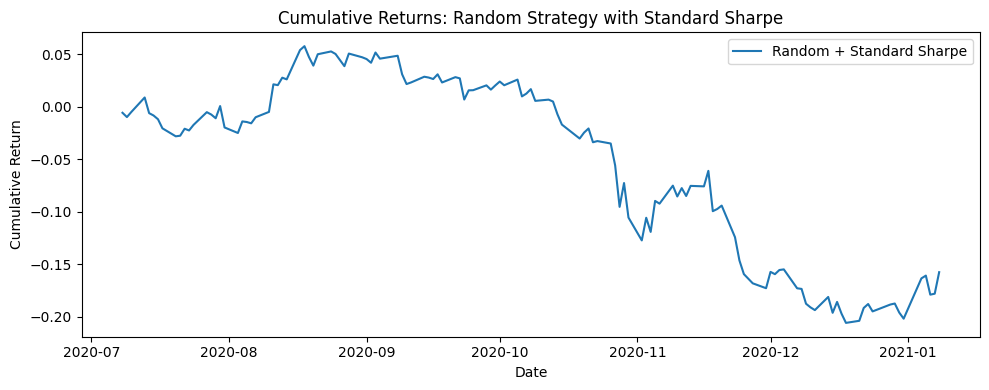

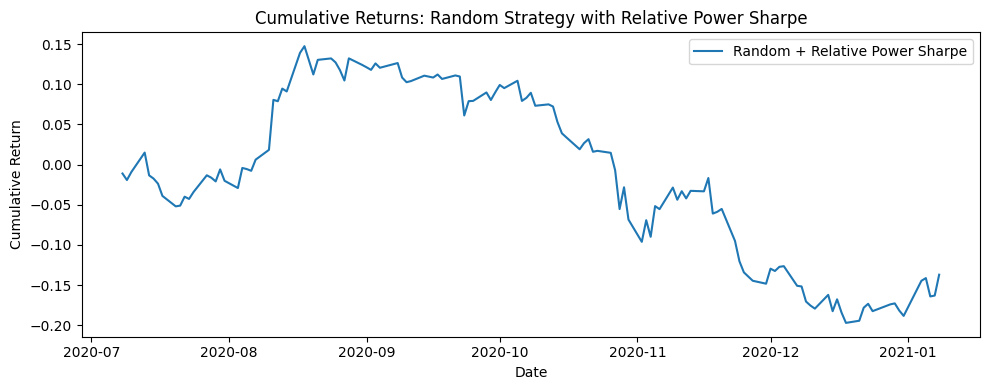

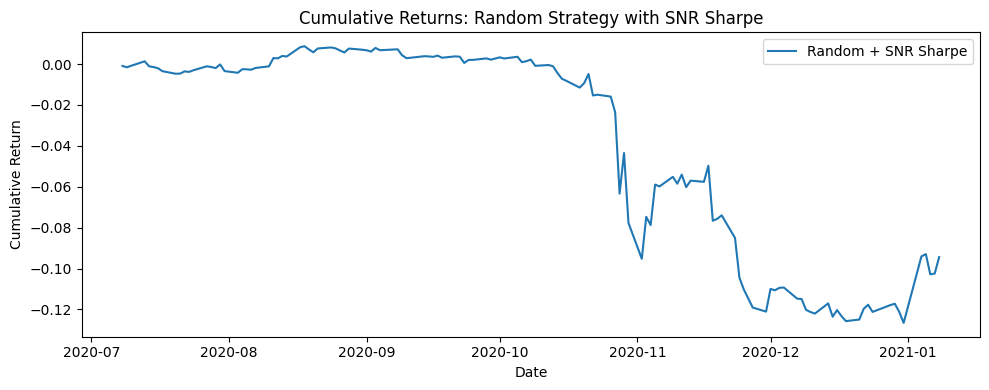

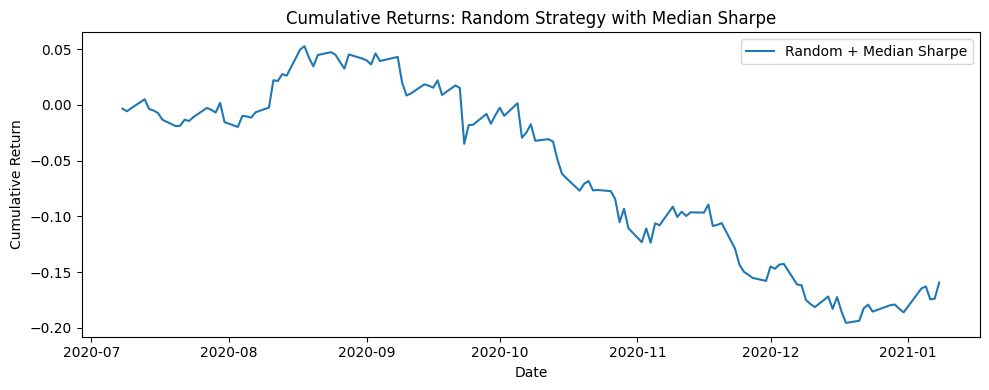

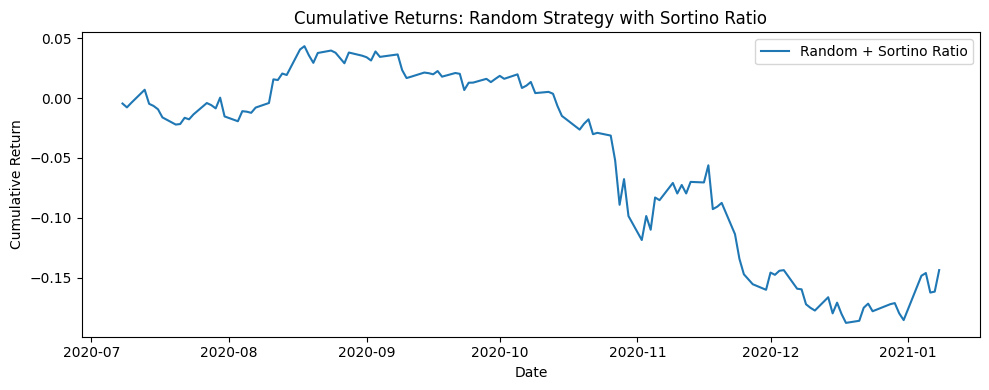

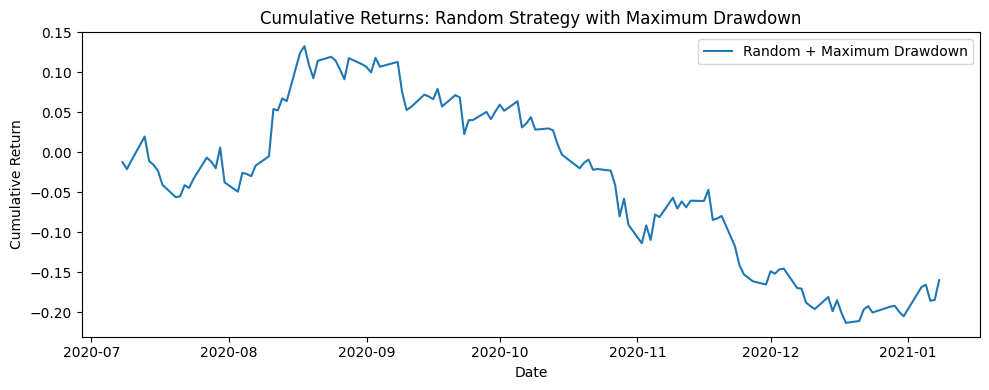

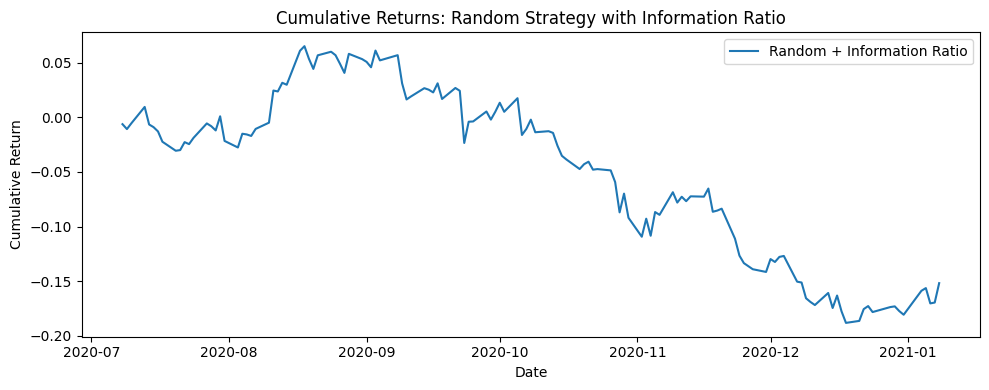

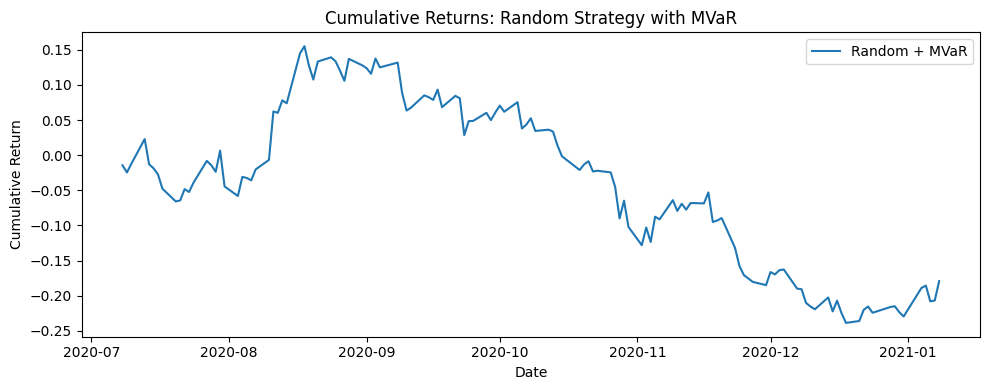

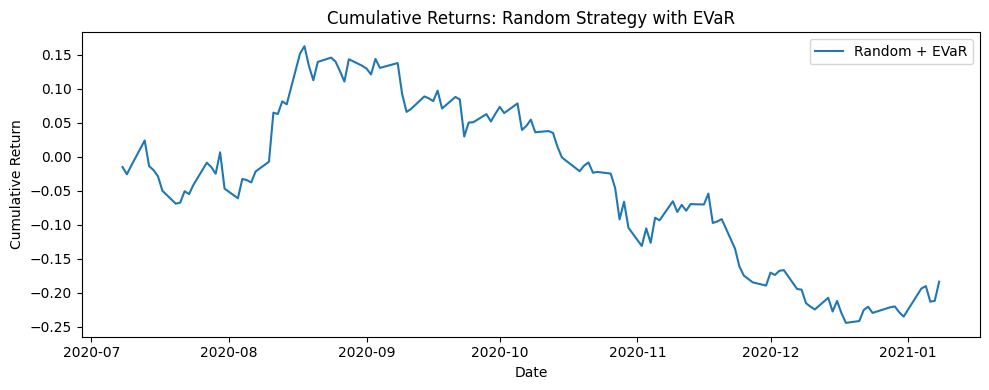

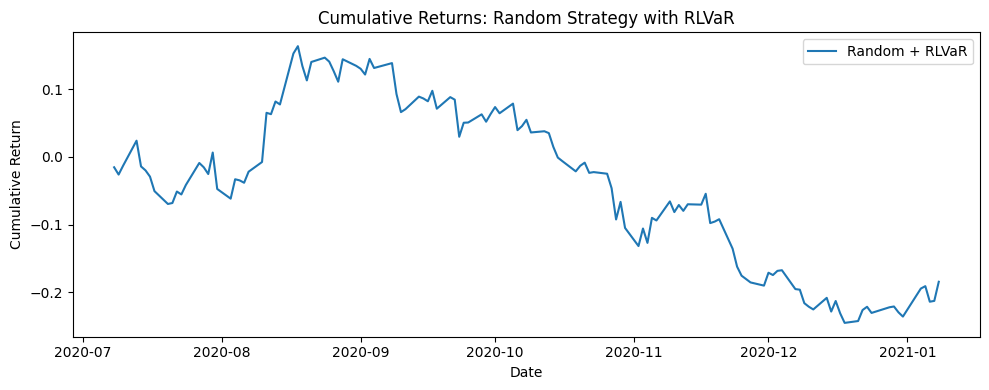

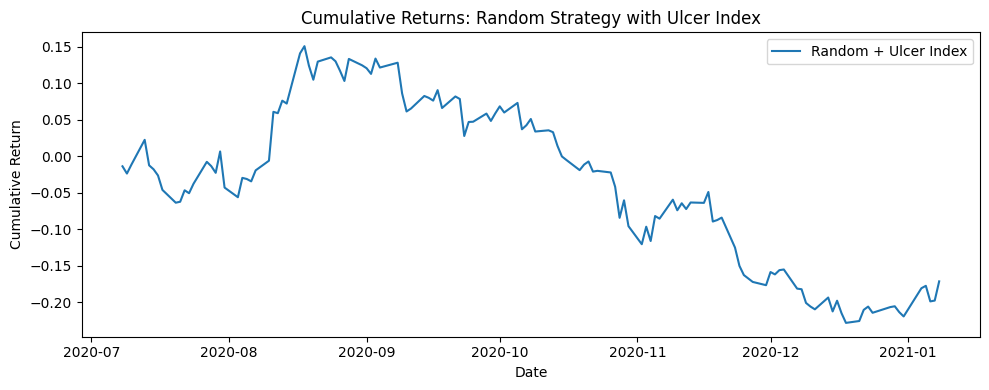

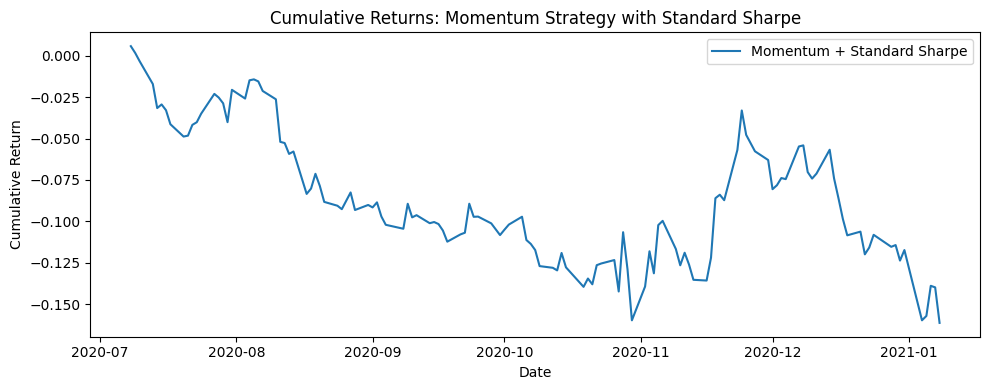

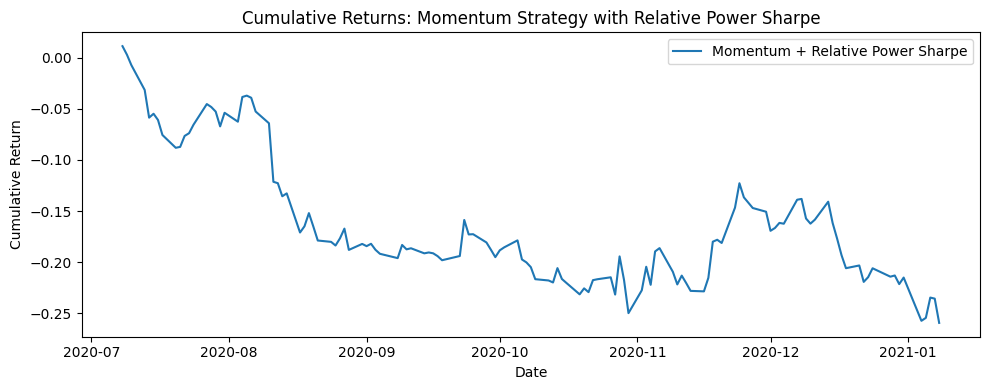

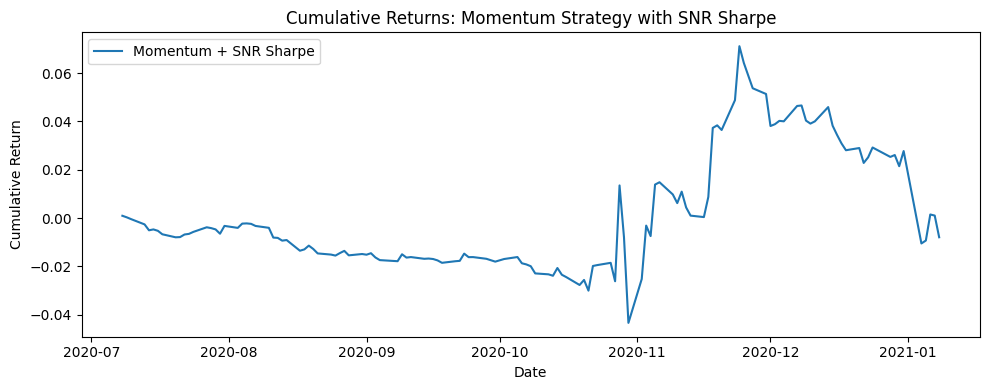

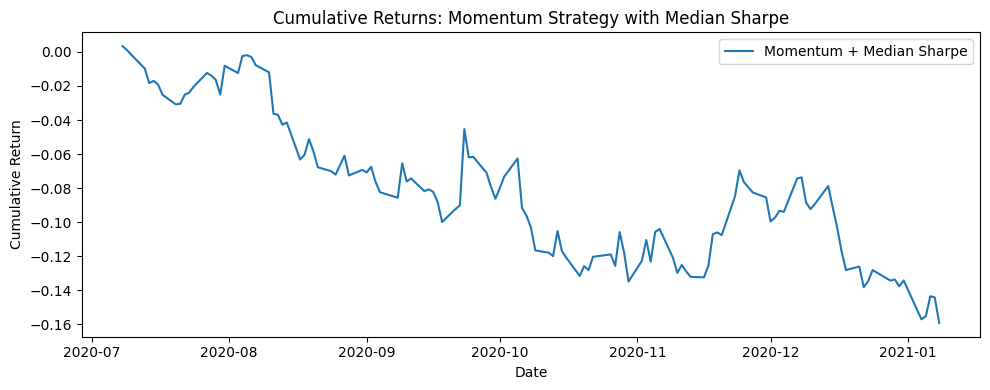

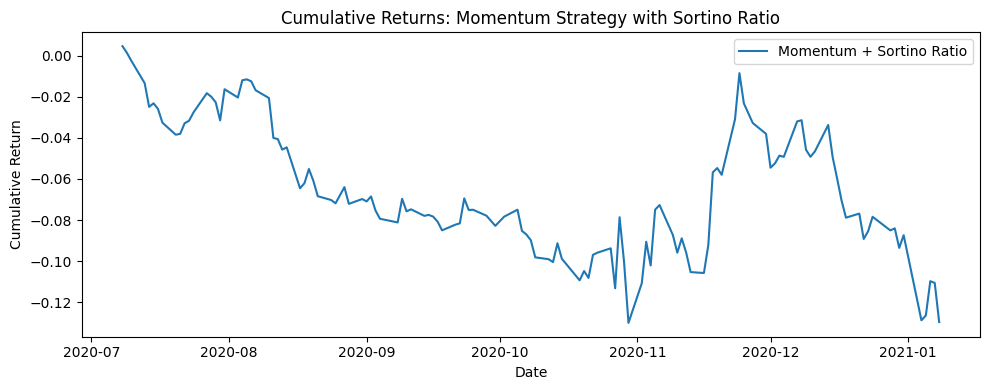

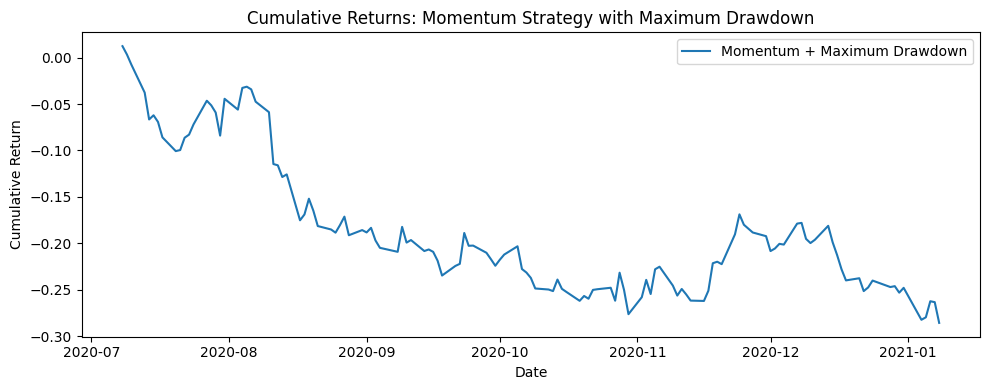

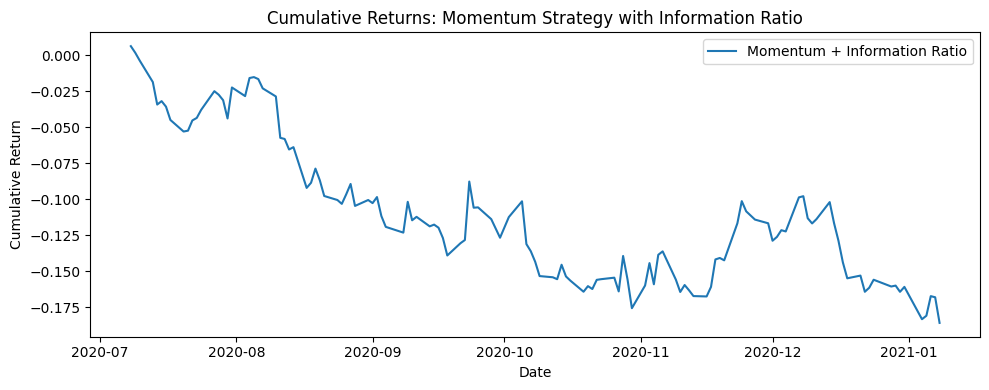

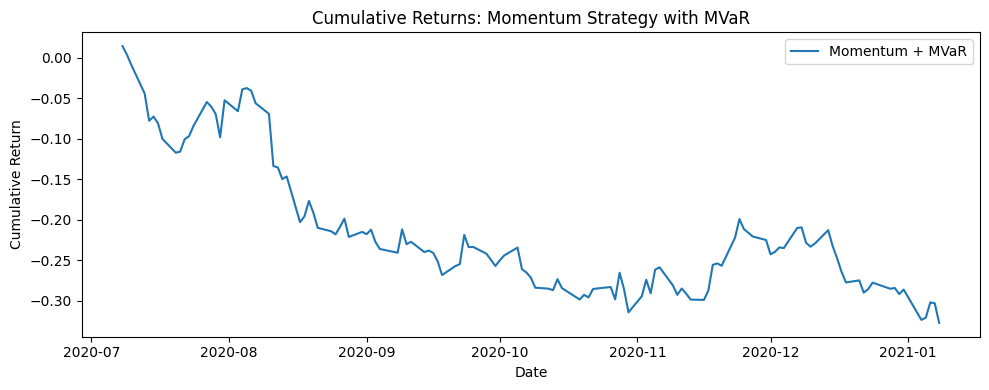

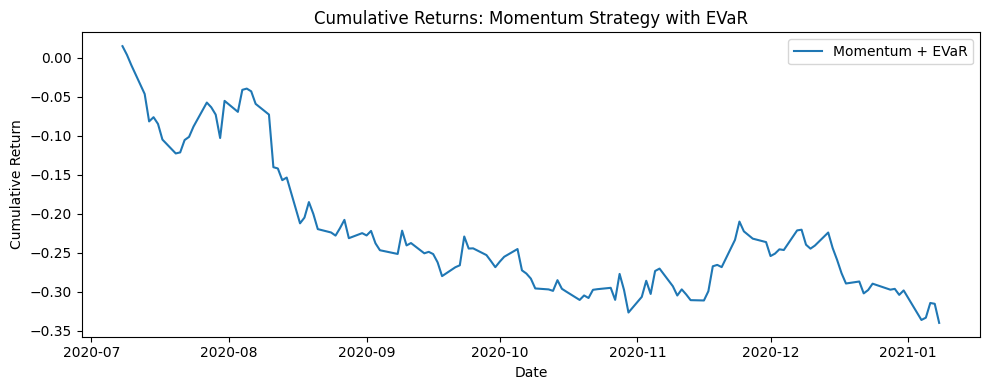

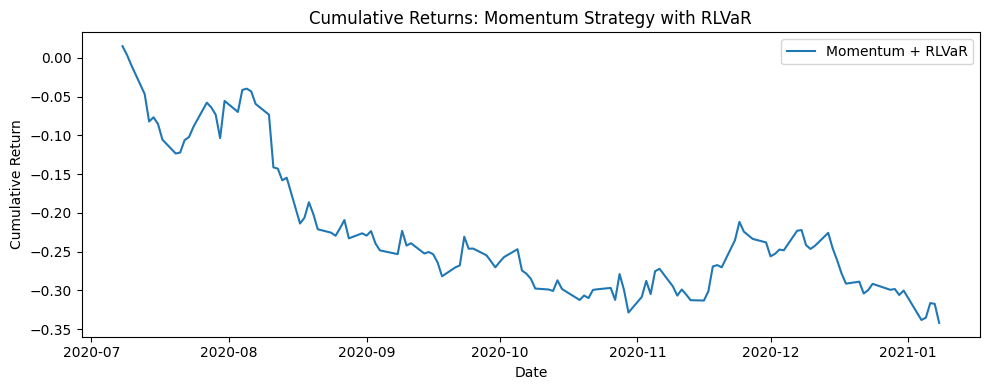

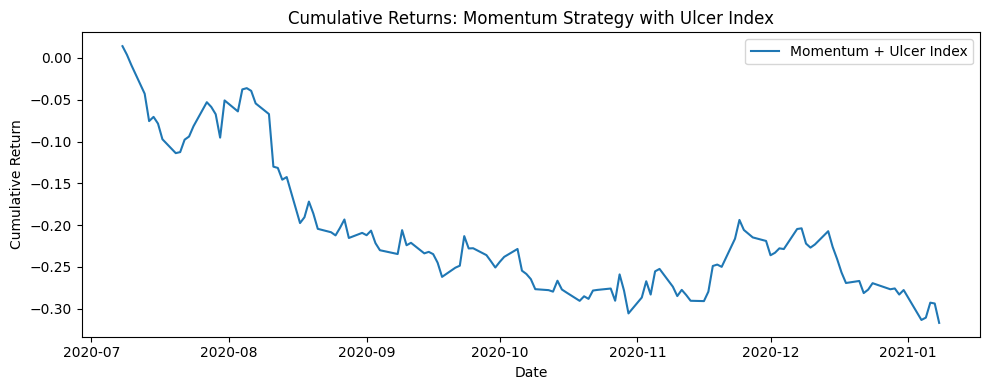

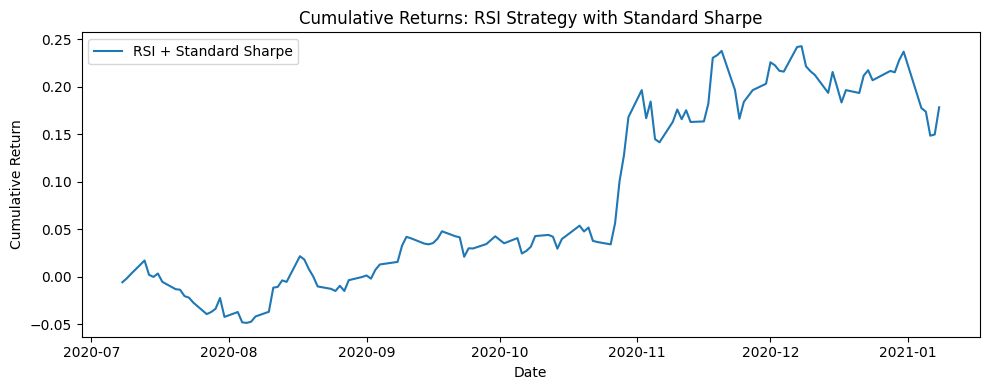

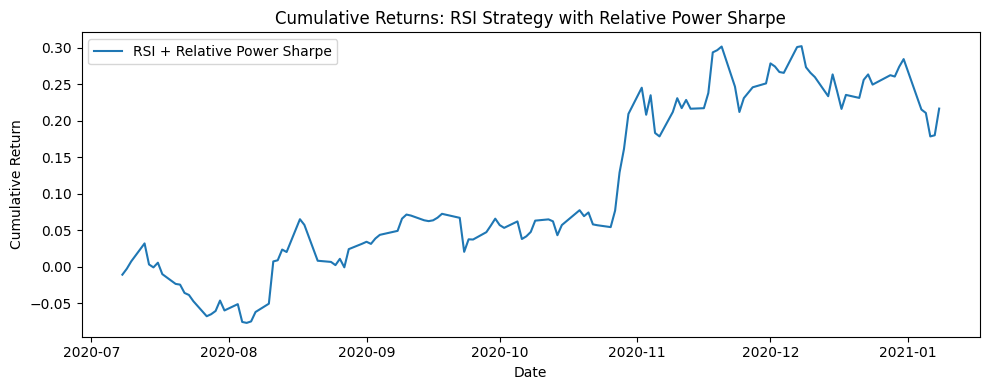

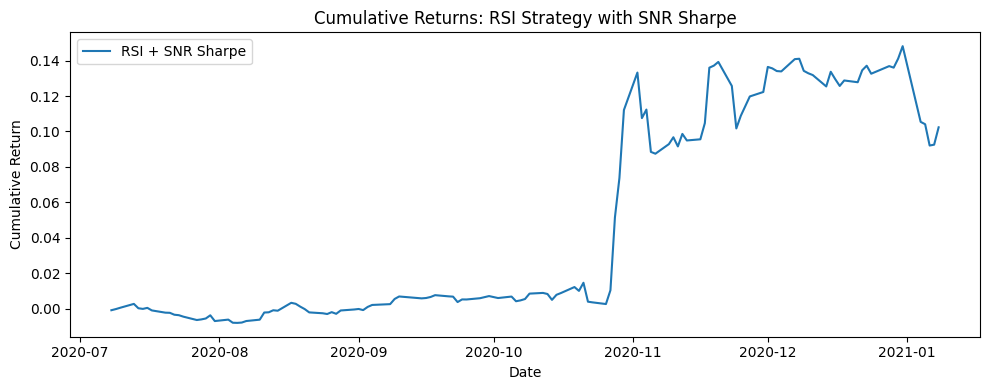

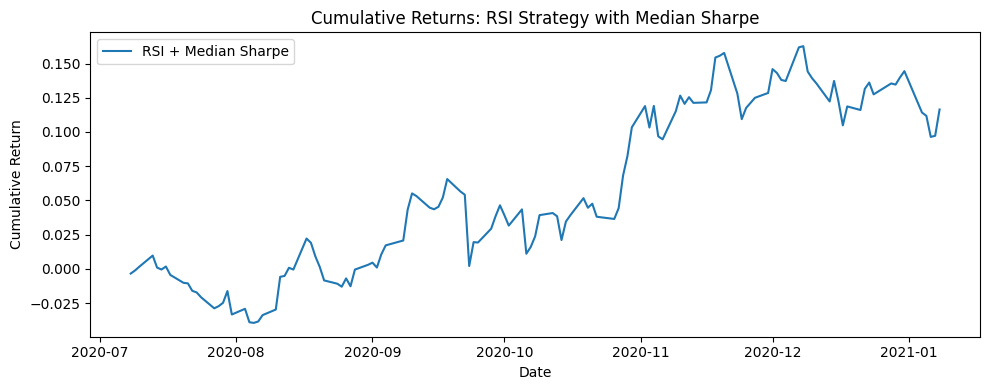

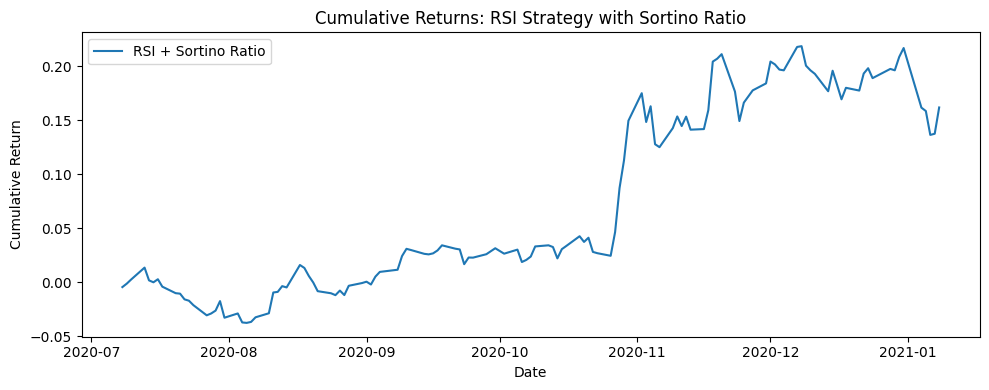

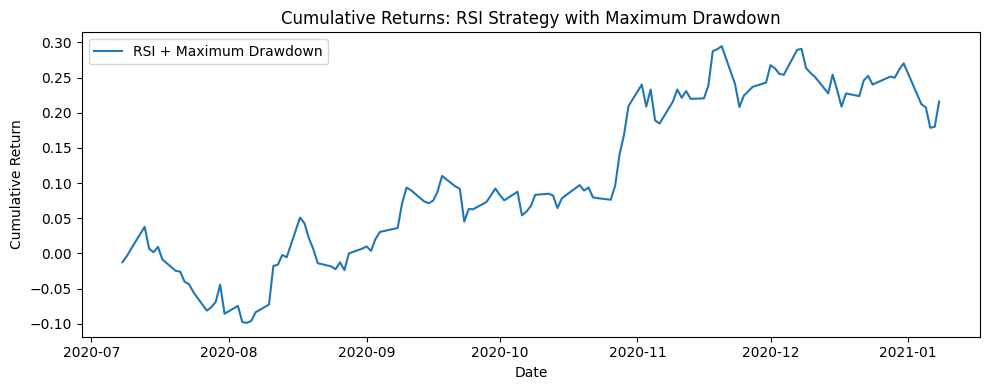

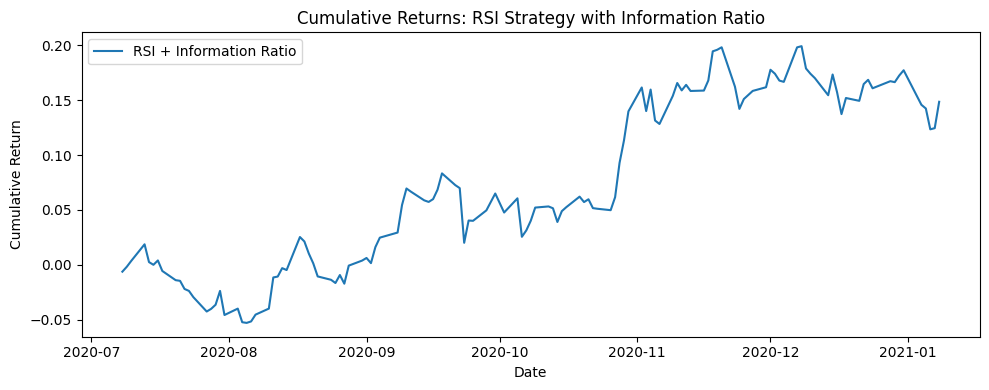

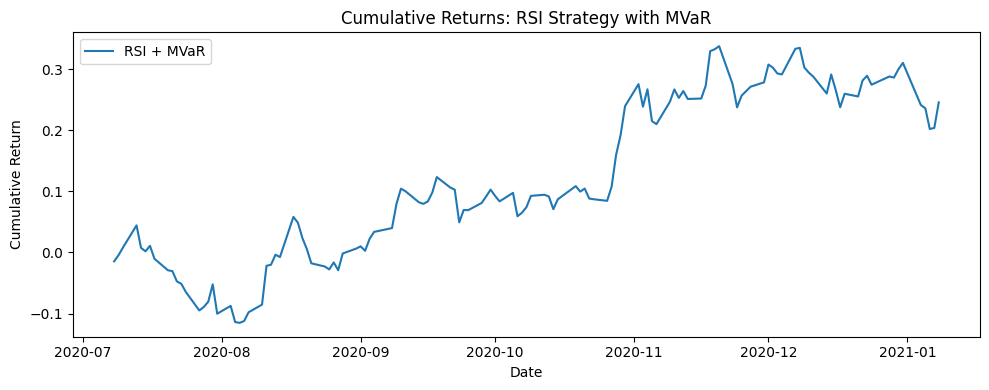

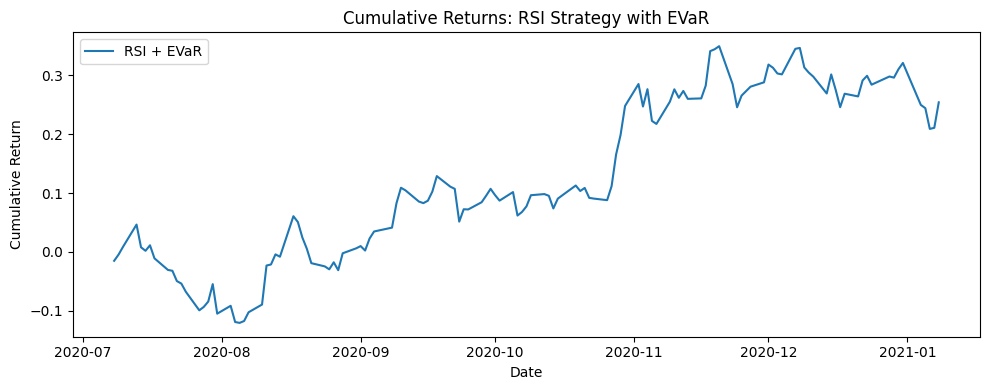

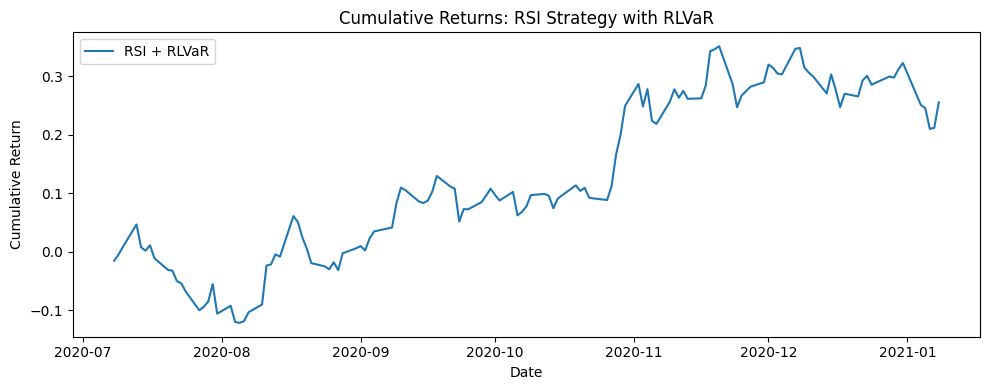

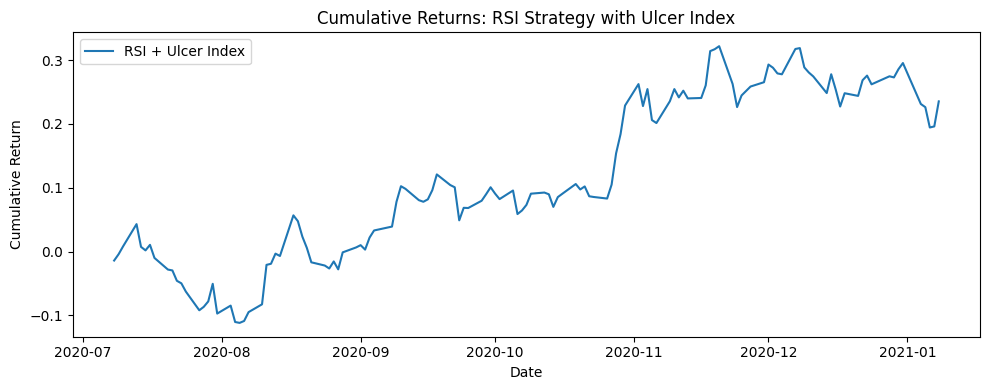

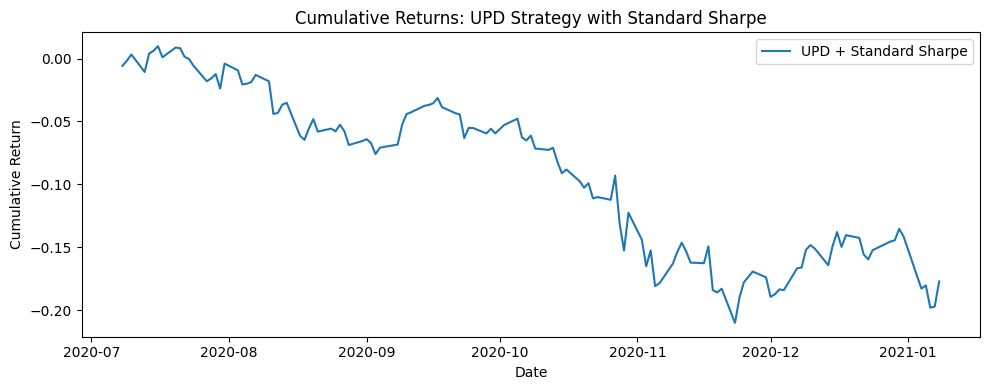

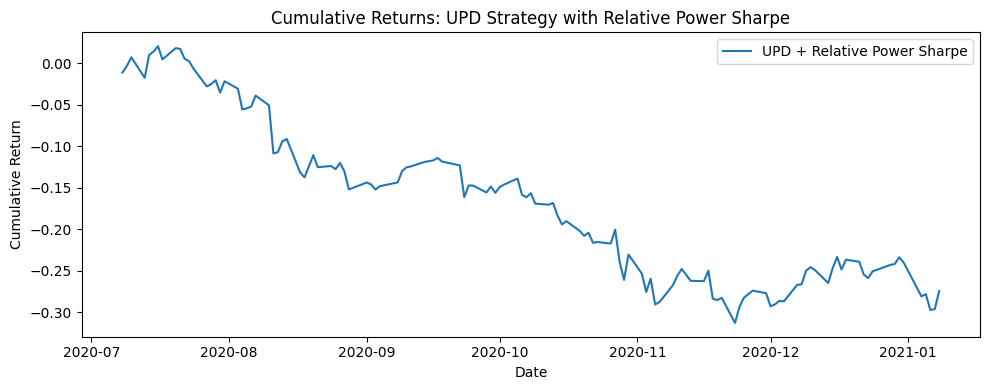

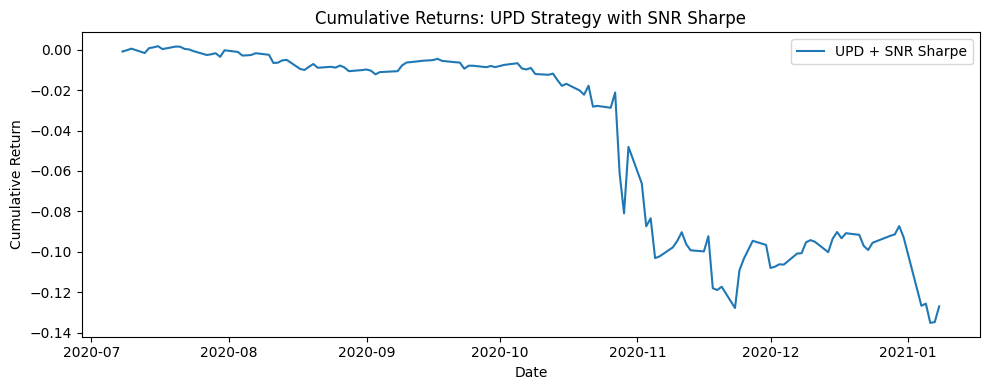

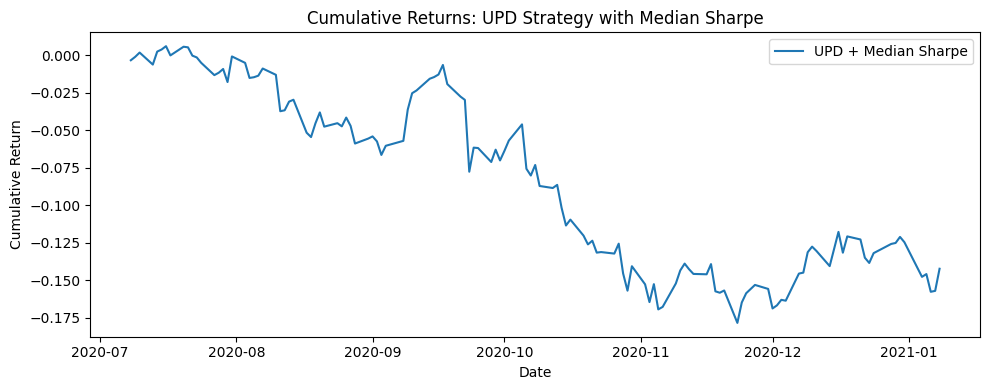

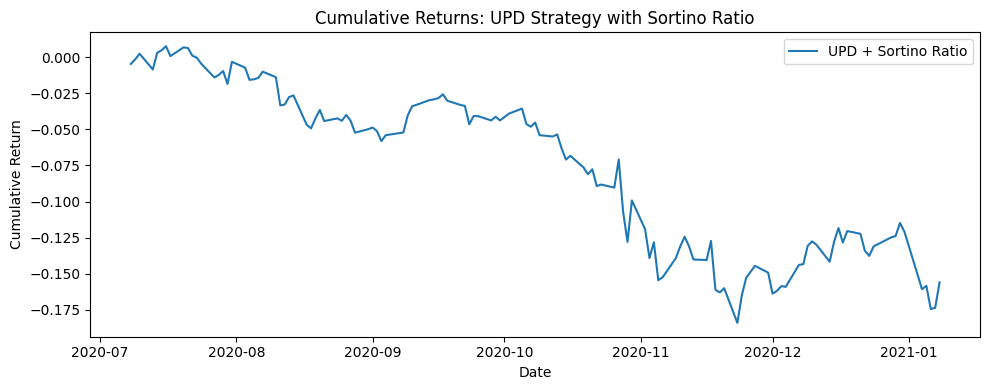

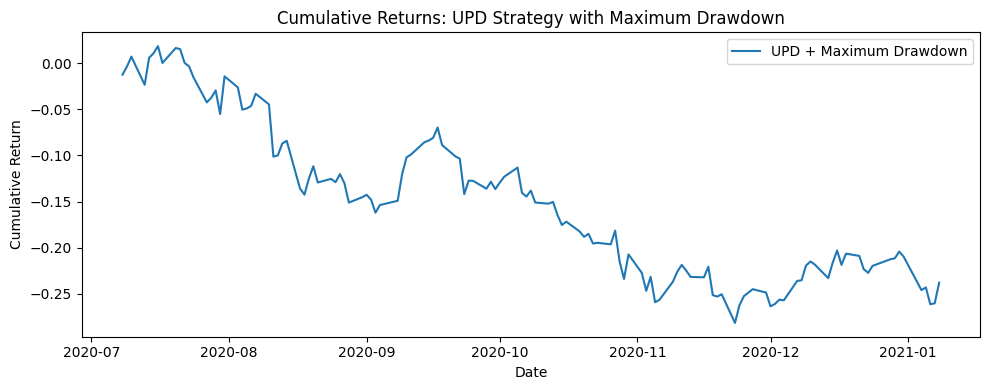

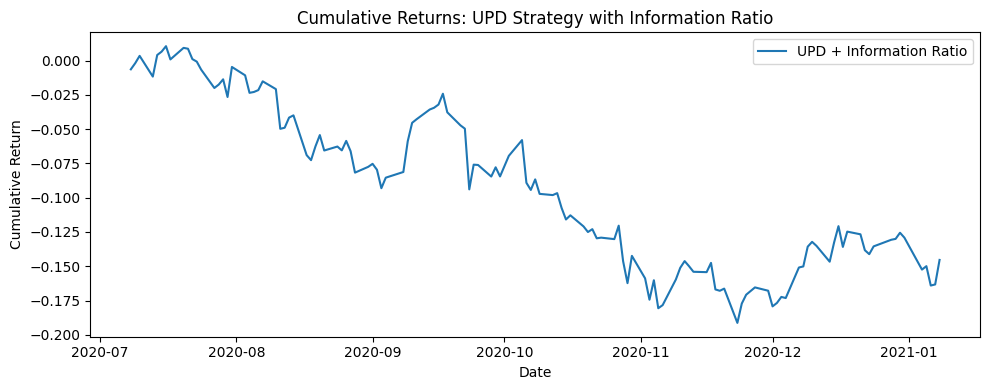

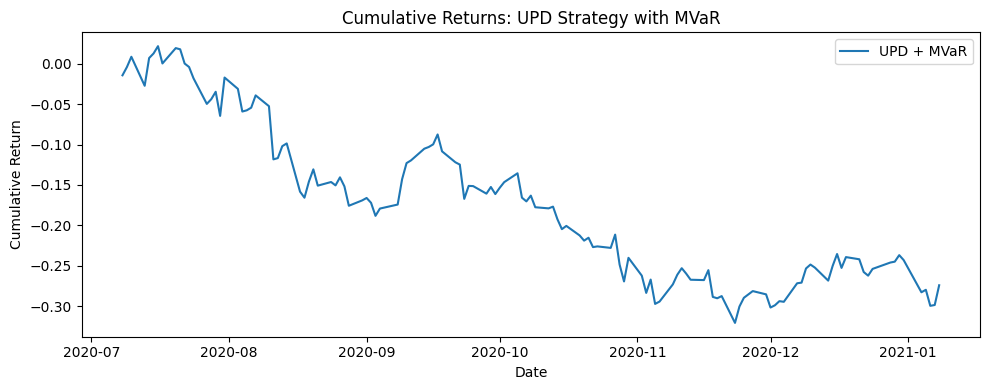

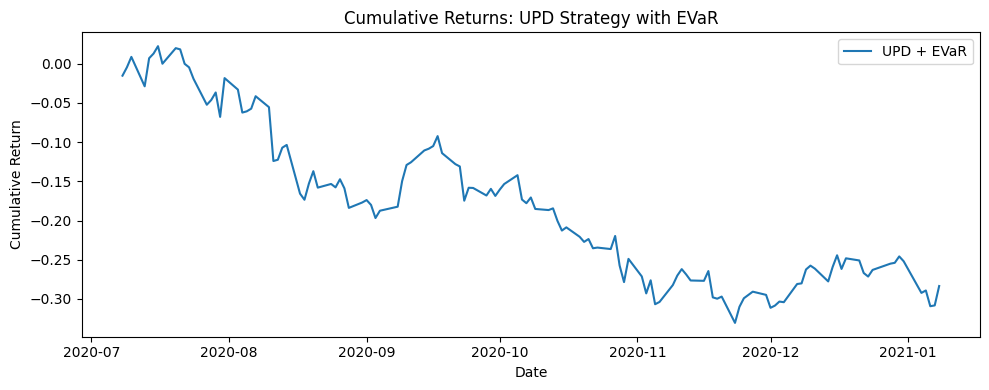

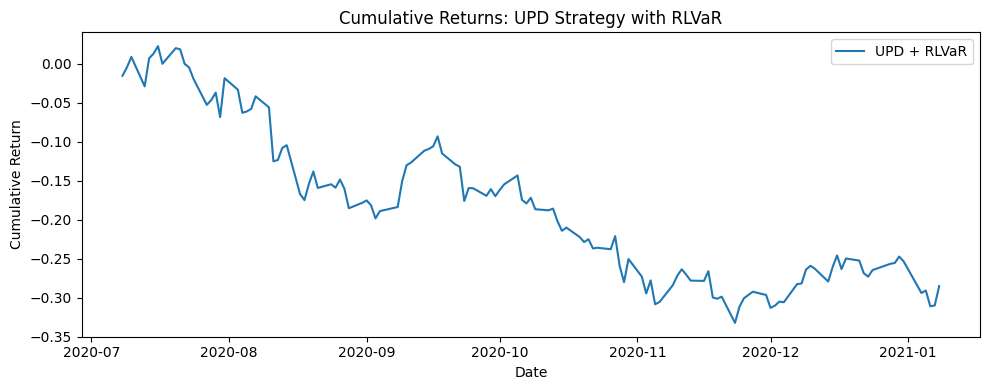

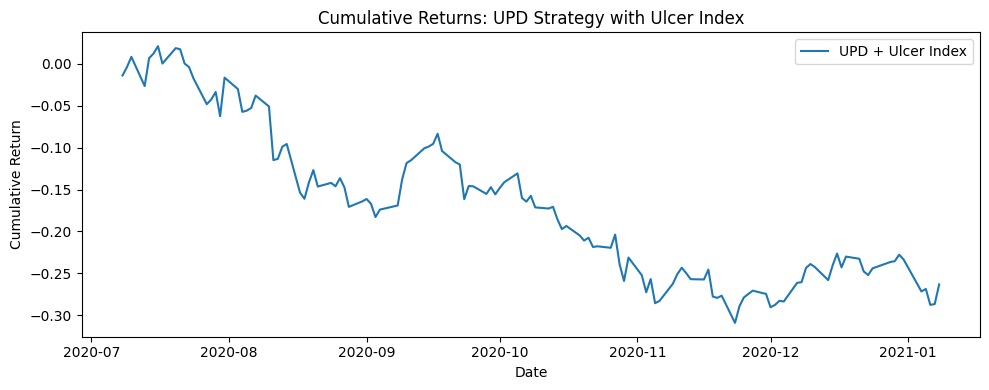

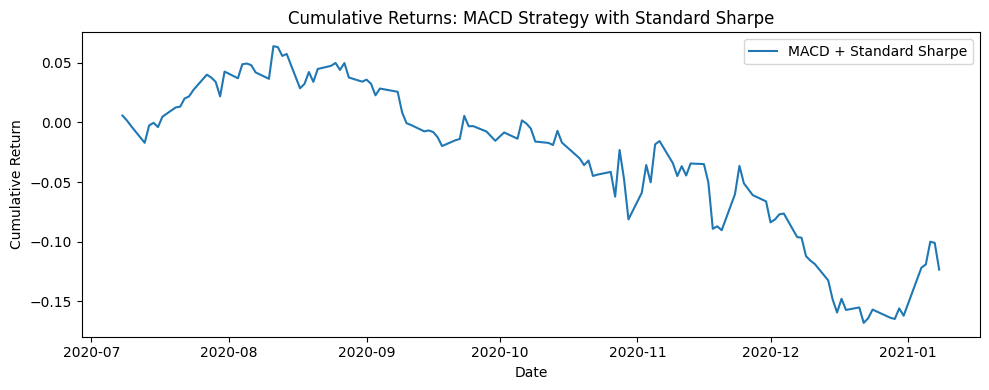

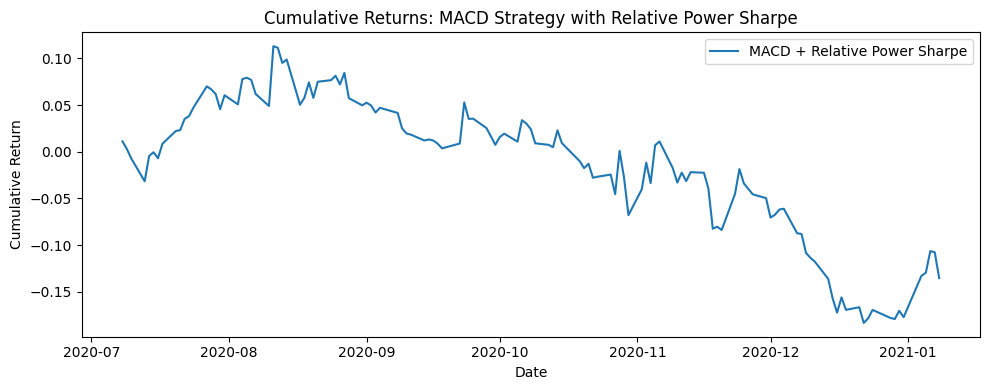

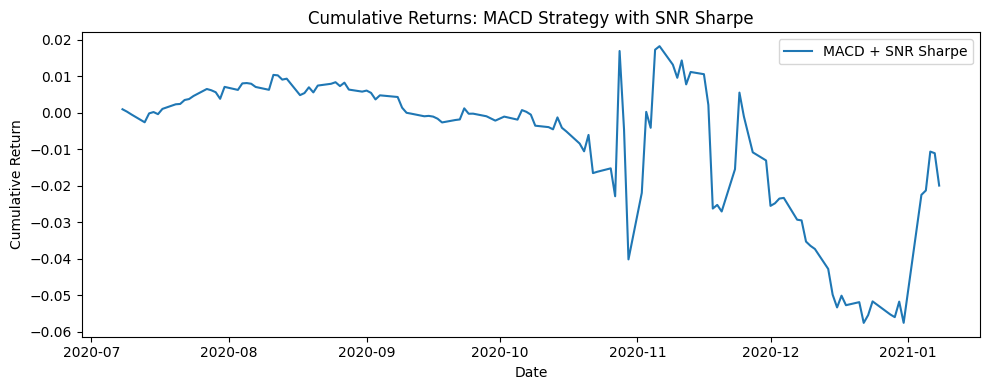

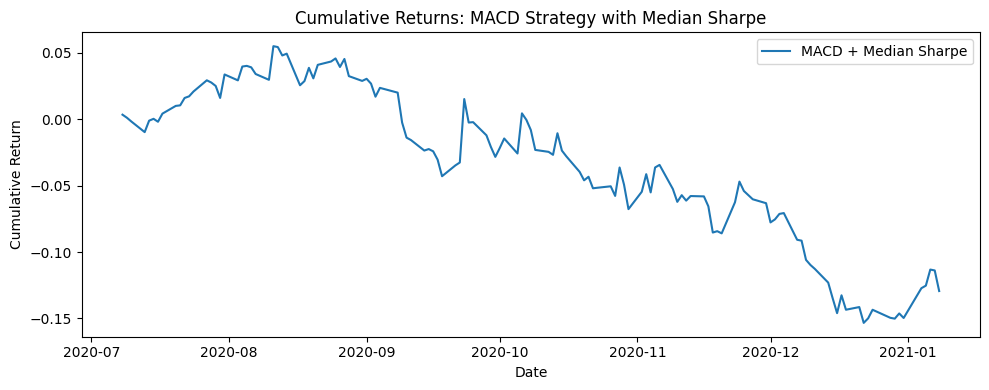

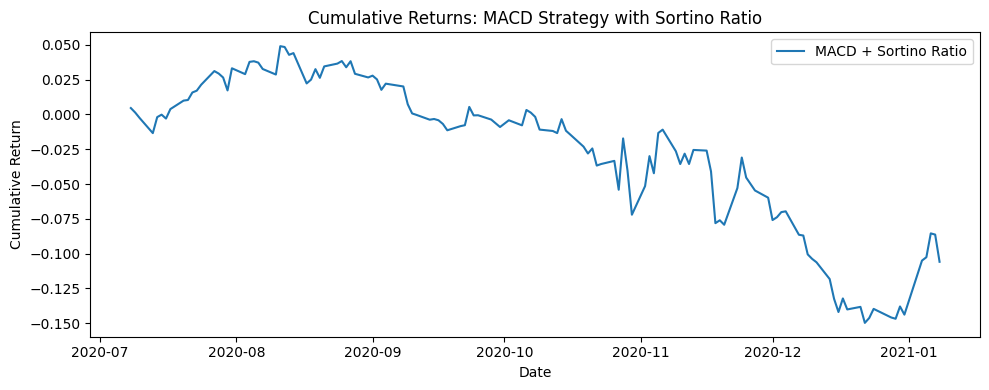

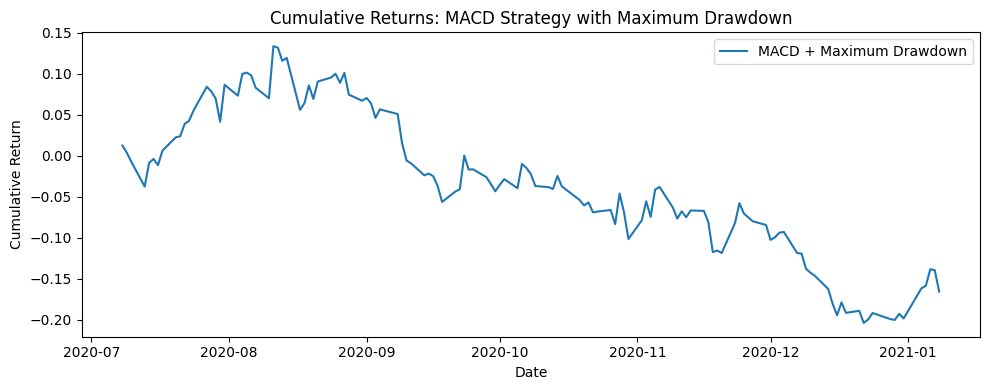

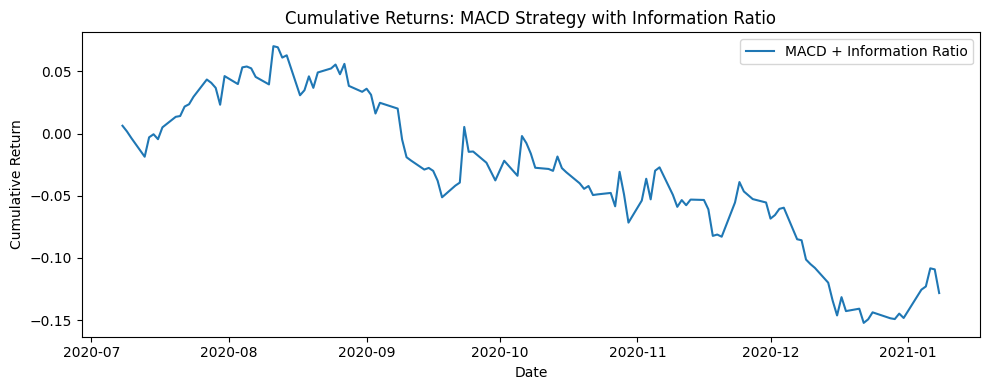

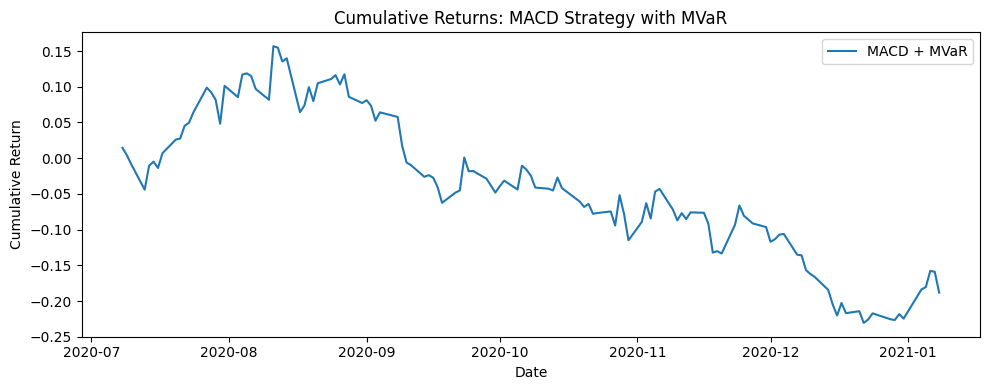

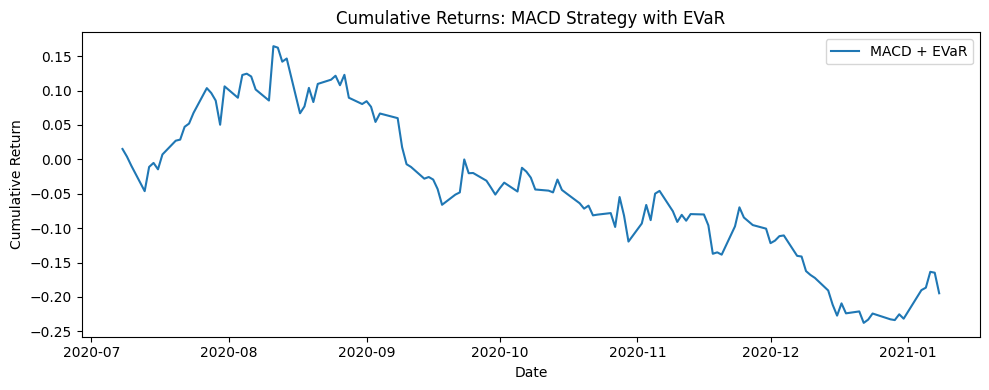

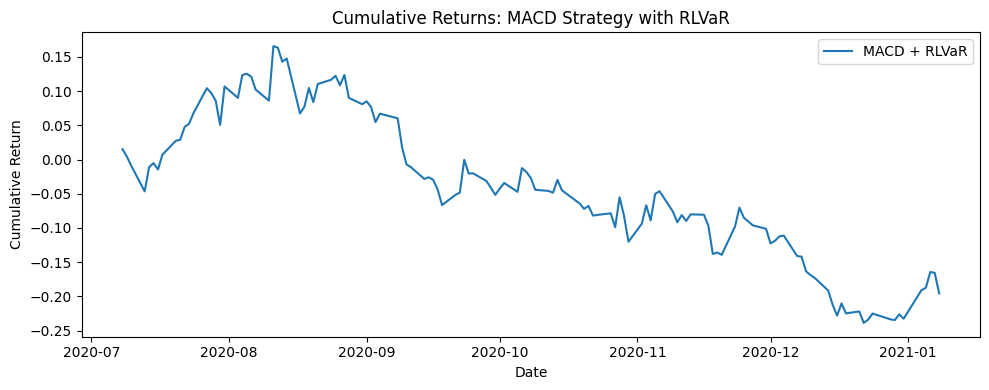

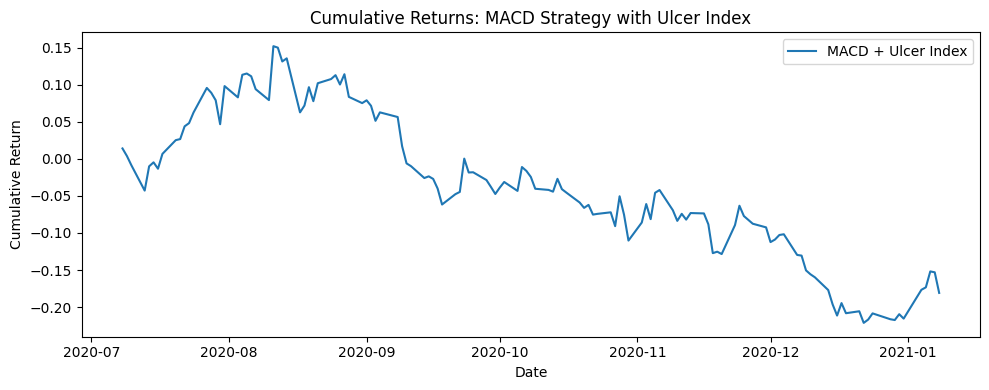

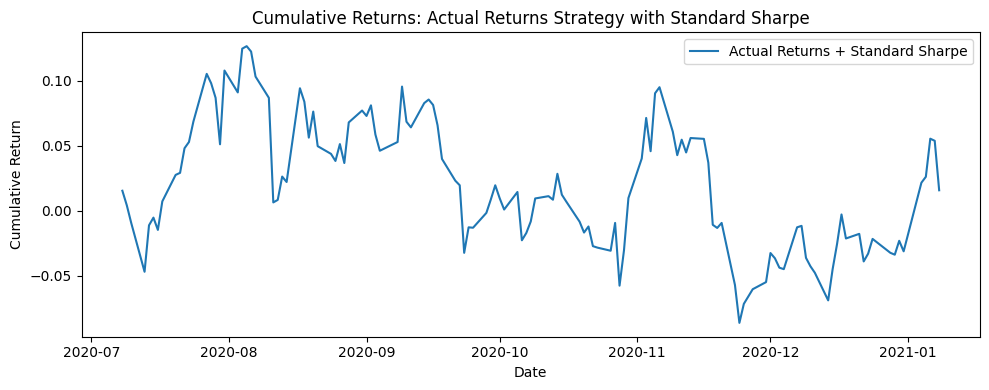

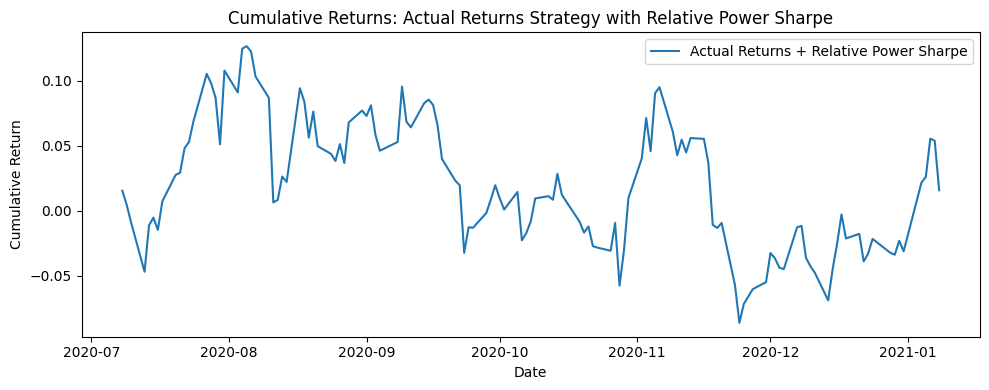

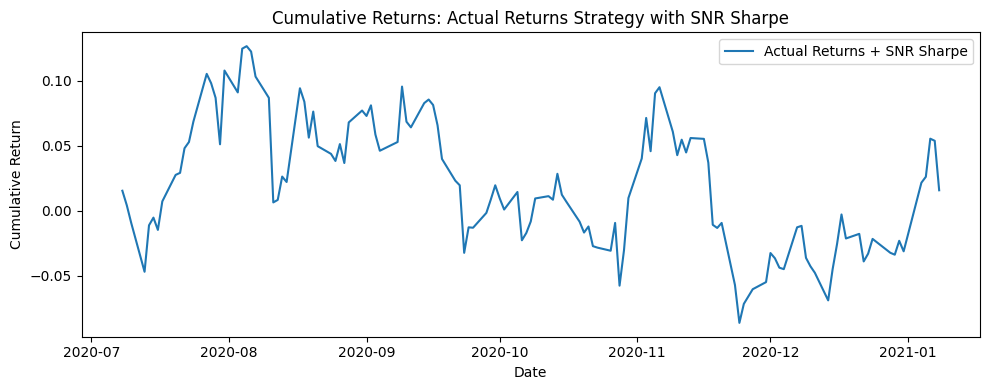

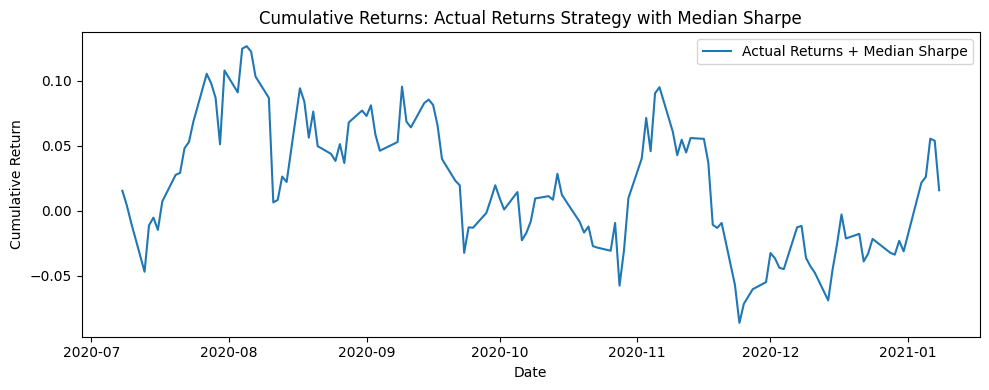

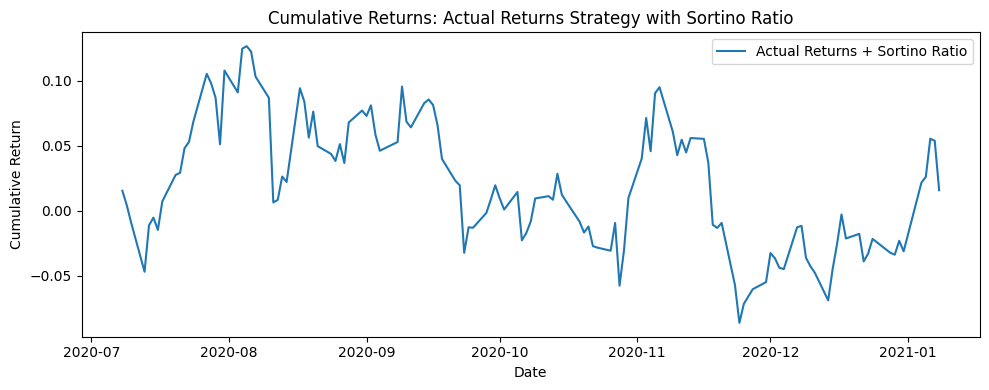

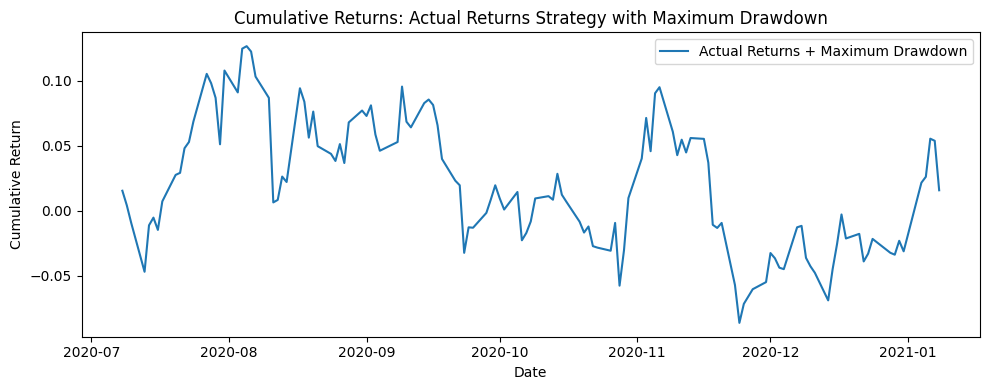

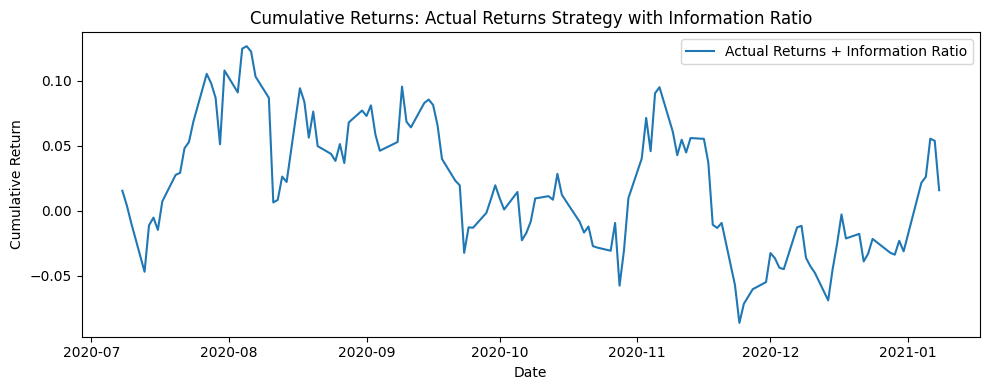

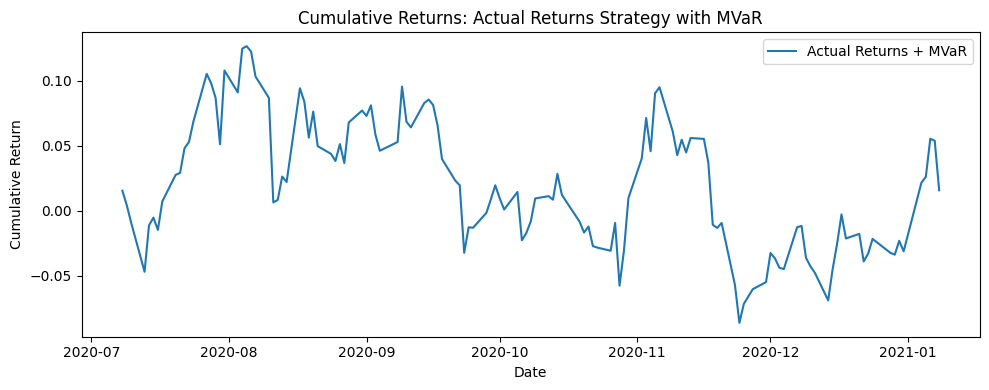

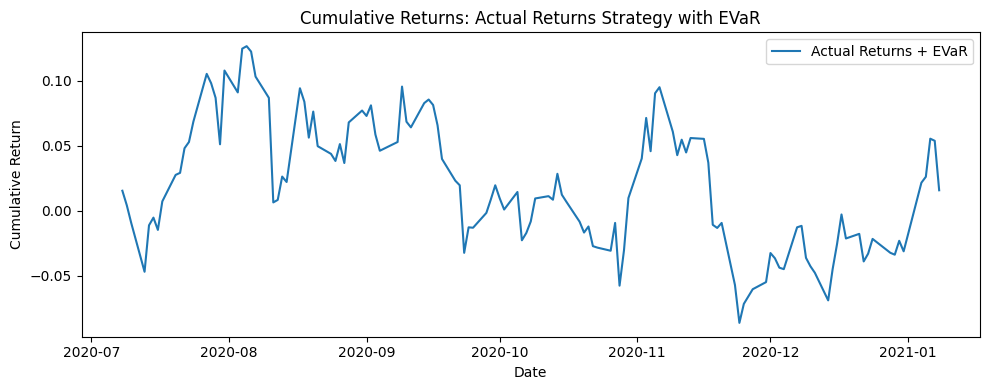

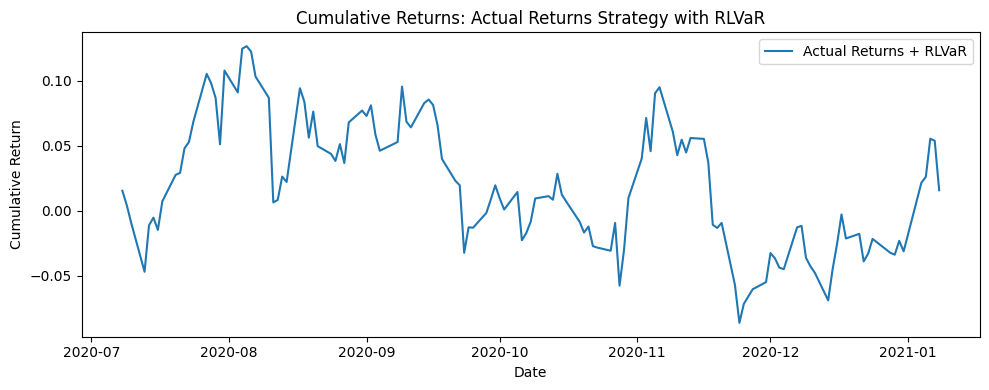

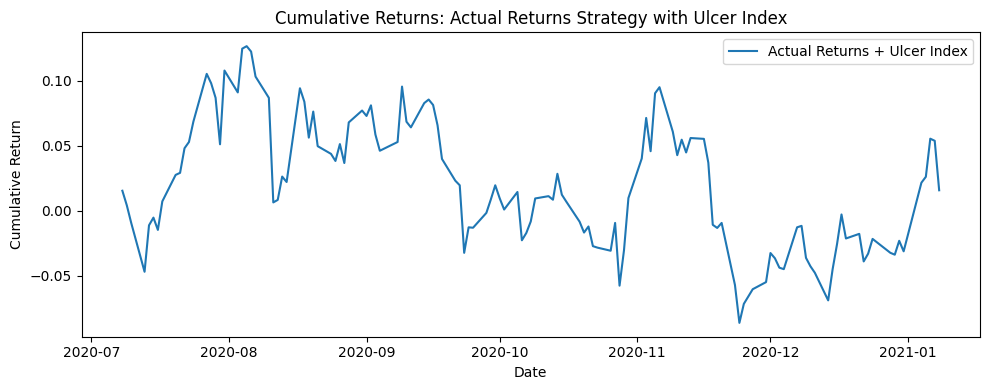


Best Risk Measure (per Trading Strategy) based on Highest Cumulative Returns:
   Trading Strategy     Risk Measure  Cumulative Return  Annualized Sharpe
55   Actual Returns  Standard Sharpe           0.015732           0.263034
46             MACD       SNR Sharpe          -0.019974          -0.232081
13         Momentum       SNR Sharpe          -0.007958          -0.052136
31              RSI            RLVaR           0.255468           1.429037
2            Random       SNR Sharpe          -0.094391          -1.401101
35              UPD       SNR Sharpe          -0.126938          -1.949641

Best Trading Strategy (per Risk Factor) based on Highest Cumulative Returns:
   Trading Strategy           Risk Measure  Cumulative Return  \
30              RSI                   EVaR           0.254132   
28              RSI      Information Ratio           0.148563   
29              RSI                   MVaR           0.245534   
27              RSI       Maximum Drawdown           0.215

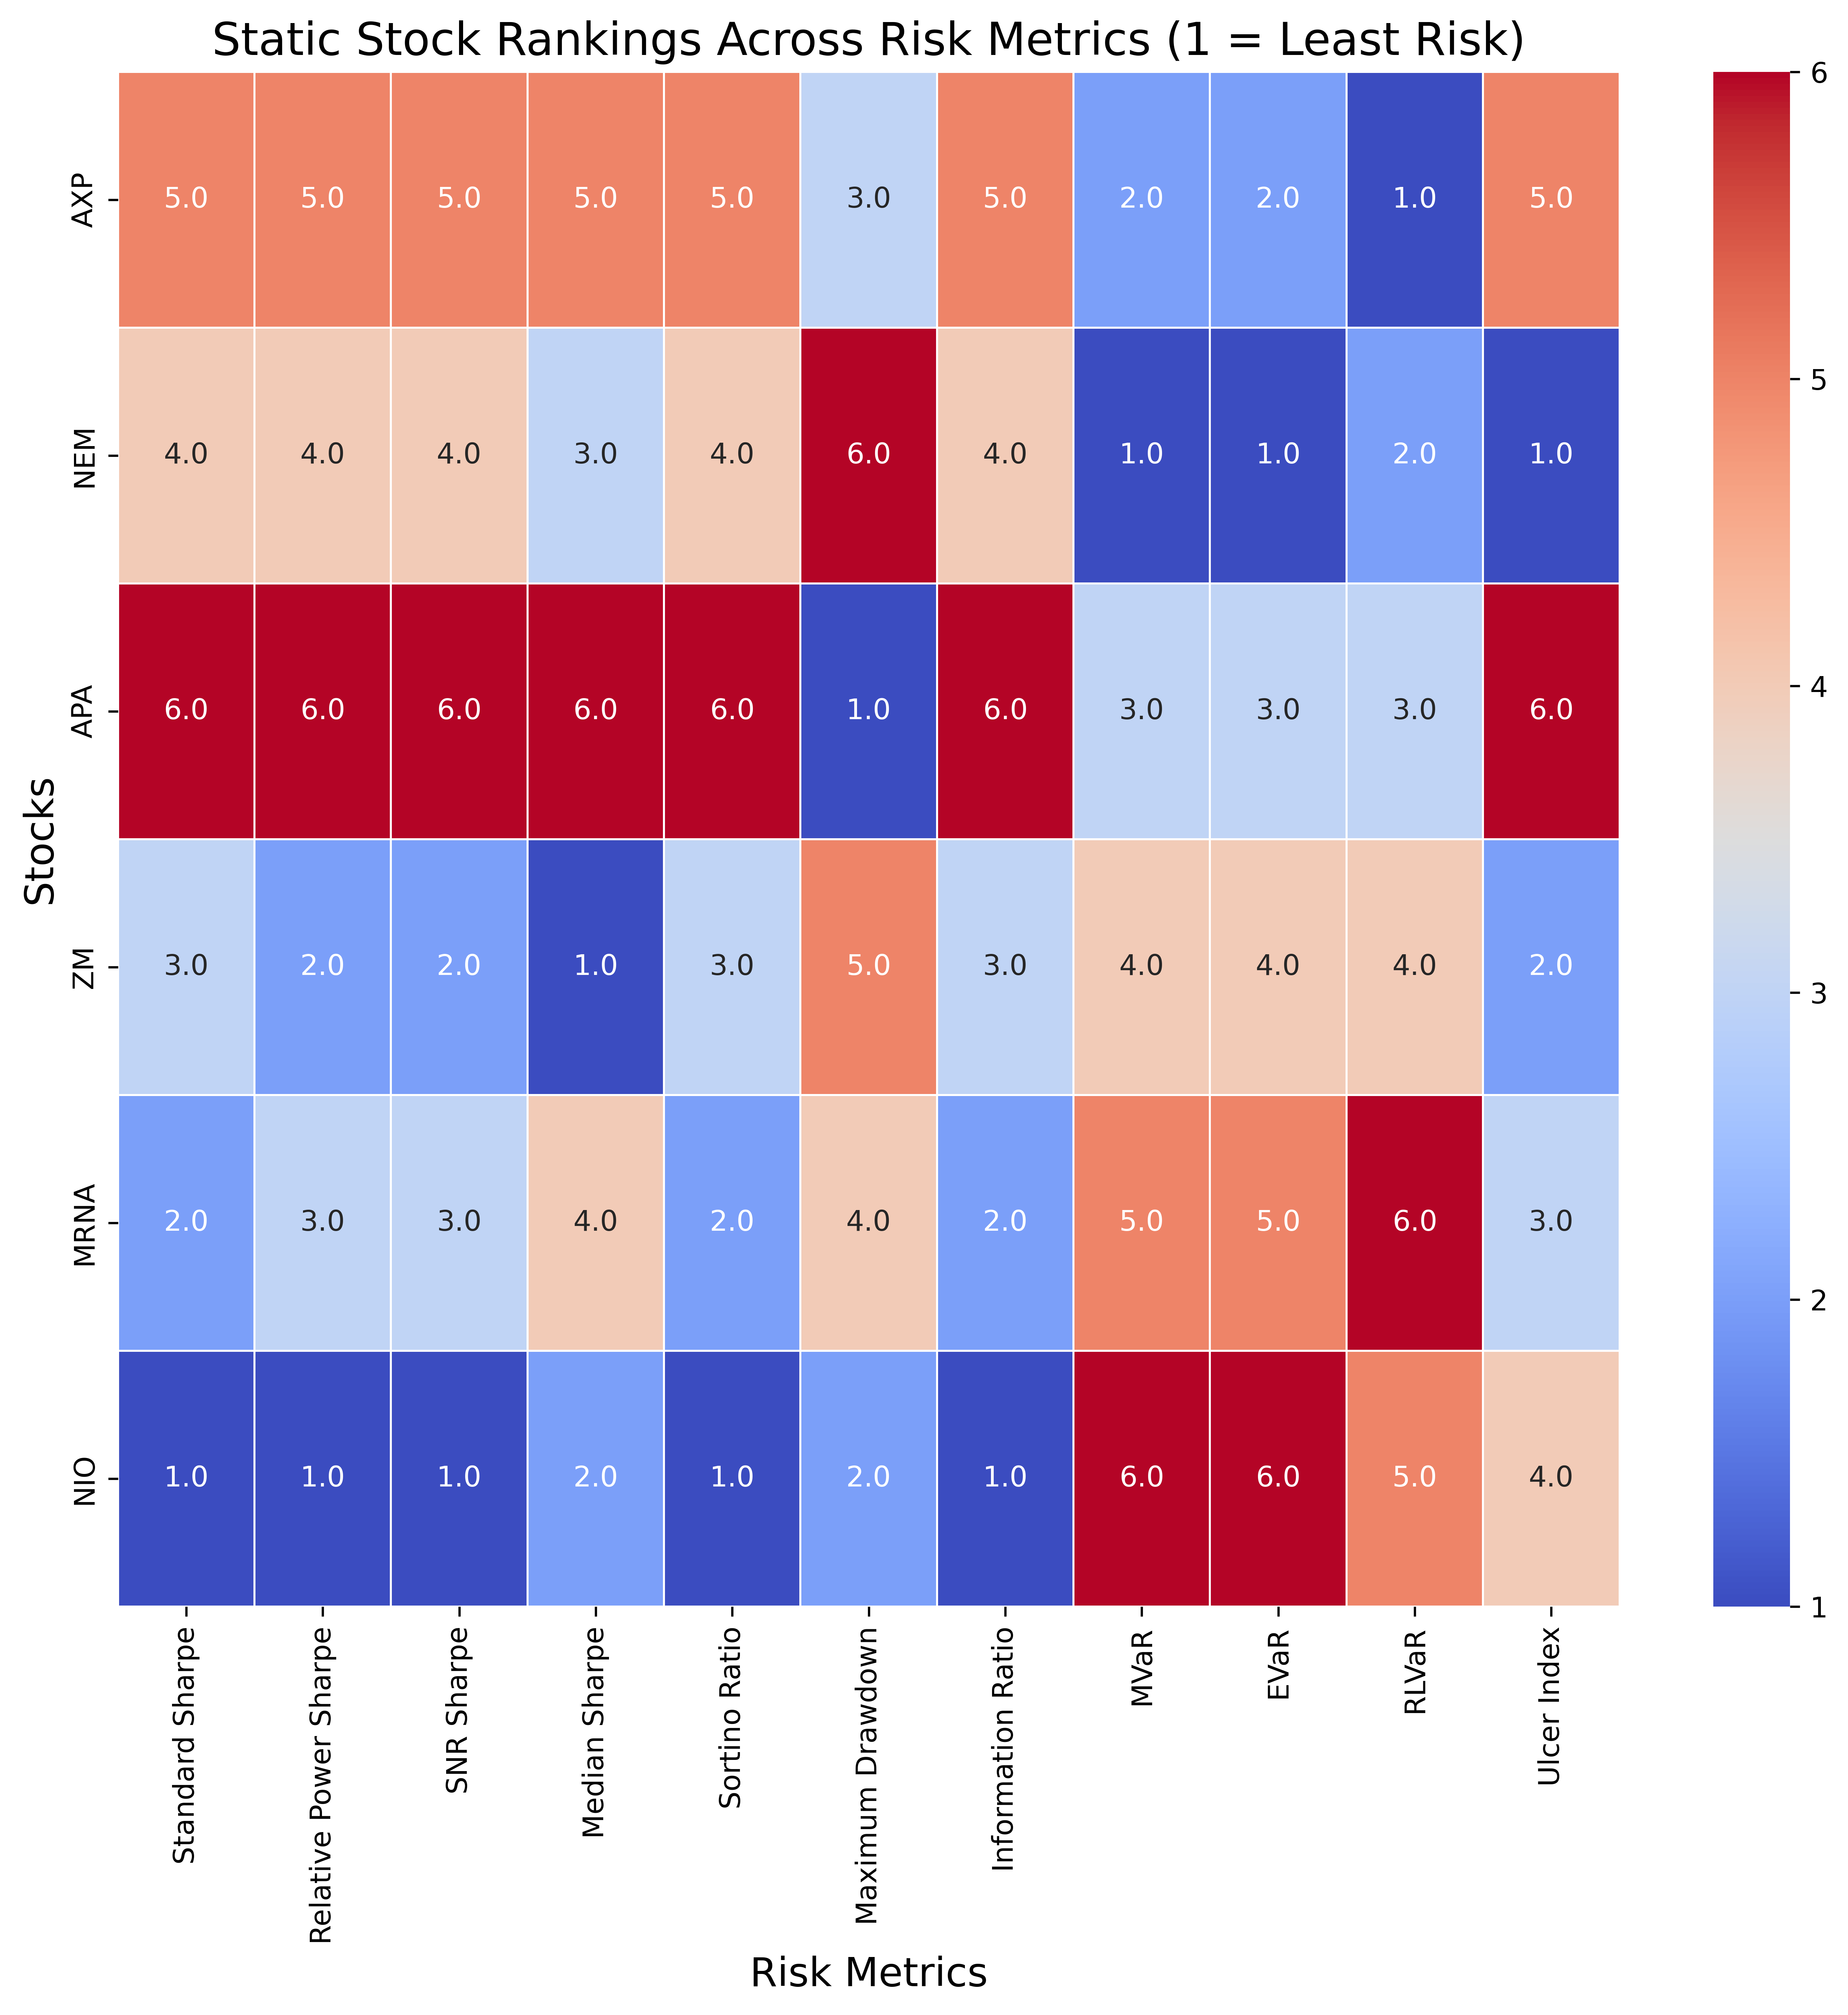

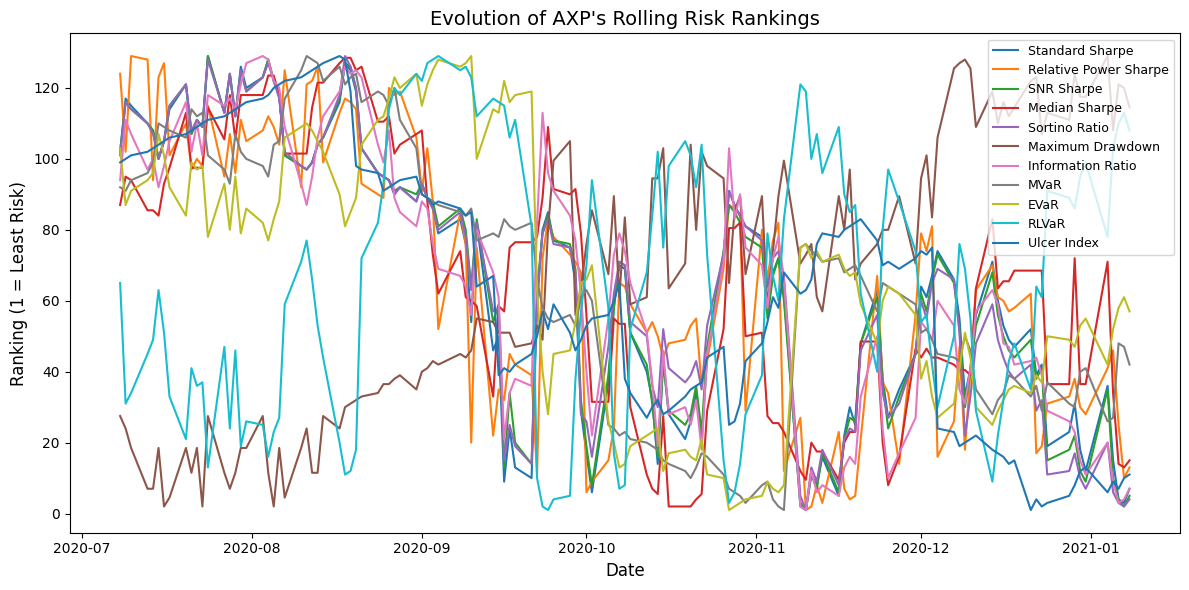

In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
from scipy.stats import norm, skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------
# 1. Define Risk Measure Functions (11 measures)
# ---------------------------------------------------
def compute_standard_sharpe(returns, trading_days_per_year=252):
    returns = returns.squeeze()
    if returns.empty or returns.std() == 0:
        return np.nan
    return (returns.mean() / returns.std()) * np.sqrt(trading_days_per_year)

def compute_relative_power_sharpe(returns):
    returns = returns.squeeze()
    if returns.empty:
        return np.nan
    target_value = np.log(4)
    annual_factor = np.sqrt(252)
    def objective(P_X):
        expectation = np.mean(np.log(1 + (returns / P_X) ** 2))
        return (expectation - target_value) ** 2
    initial_guess = 1.0
    result = minimize(objective, initial_guess, bounds=[(0, None)])
    if result.success and not np.isnan(result.x[0]):
        P_X = float(result.x[0])
        return (np.mean(np.log(1+returns)) / P_X)*annual_factor if P_X > 0 else np.nan
    else:
        return np.nan

def compute_snr_sharpe(returns, trading_days_per_year=252):
    returns = returns.squeeze()
    if returns.empty:
        return np.nan
    log_returns = np.log(1 + returns)
    mean_lr = log_returns.mean()
    std_error = log_returns.std() / np.sqrt(len(log_returns))
    return (mean_lr / std_error) * np.sqrt(trading_days_per_year) if std_error > 0 else np.nan

def compute_median_sharpe(returns, trading_days_per_year=252):
    returns = returns.squeeze()
    if returns.empty:
        return np.nan
    med = np.median(returns)
    mad = np.median(np.abs(returns - med))
    return (med / mad) * np.sqrt(trading_days_per_year) if mad > 0 else np.nan

def compute_sortino_ratio(returns, trading_days_per_year=252):
    returns = returns.squeeze()
    if returns.empty:
        return np.nan
    mean_ret = returns.mean()
    neg_returns = returns[returns < 0]
    downside_std = neg_returns.std()
    return (mean_ret / downside_std) * np.sqrt(trading_days_per_year) if downside_std > 0 else np.nan

def compute_max_drawdown(returns):
    returns = returns.squeeze()
    if returns.empty:
        return np.nan
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.cummax()
    dd = (cum_returns - peak) / peak
    return dd.min()

def compute_information_ratio(returns, benchmark_returns, trading_days_per_year=252):
    returns = returns.squeeze()
    benchmark_returns = benchmark_returns.squeeze()
    if returns.empty or benchmark_returns.empty:
        return np.nan
    aligned = pd.concat([returns, benchmark_returns], axis=1).dropna()
    if aligned.empty:
        return np.nan
    ex_ret = aligned.iloc[:, 0] - aligned.iloc[:, 1]
    if ex_ret.std() == 0:
        return np.nan
    return (ex_ret.mean() / ex_ret.std()) * np.sqrt(trading_days_per_year)

def compute_mvar(returns, confidence_level=0.95):
    returns = returns.squeeze()
    if returns.empty:
        return np.nan
    mean_ret = returns.mean()
    std_dev = returns.std()
    skewness = skew(returns)
    excess_kurt = kurtosis(returns, fisher=True)
    z = norm.ppf(confidence_level)
    mvar = (mean_ret + z * std_dev +
            ((z**2 - 1) / 6) * skewness * std_dev +
            ((z**3 - 3*z) / 24) * excess_kurt * std_dev)
    return float(mvar)

def compute_evar(returns, alpha=0.95):
    returns = returns.squeeze()
    if returns.empty:
        return np.nan
    z_vals = np.linspace(0.01, 10, 100)
    mgf = lambda t: np.mean(np.exp(t * returns))
    evar_vals = [(1/t)*(np.log(mgf(t)) - np.log(alpha)) for t in z_vals if mgf(t) > 0]
    return min(evar_vals) if evar_vals else np.nan

def compute_rlvar(returns, alpha=0.95, kappa=0.5):
    returns = returns.squeeze()
    if returns.empty:
        return np.nan
    mgf_kappa = lambda t: np.mean((1 + t * returns / kappa) ** kappa)
    z_vals = np.linspace(0.01, 10, 100)
    rlvar_vals = [(1/t)*(np.log(mgf_kappa(t)) - np.log(alpha)) for t in z_vals if mgf_kappa(t) > 0]
    return min(rlvar_vals) if rlvar_vals else np.nan

def compute_ulcer_index(returns):
    returns = returns.squeeze()
    if returns.empty:
        return np.nan
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.cummax()
    dd = (cum_returns - peak) / peak
    return np.sqrt(np.mean(dd**2))

# Dictionary of risk measures
risk_measures = {
    'Standard Sharpe': compute_standard_sharpe,
    'Relative Power Sharpe': compute_relative_power_sharpe,
    'SNR Sharpe': compute_snr_sharpe,
    'Median Sharpe': compute_median_sharpe,
    'Sortino Ratio': compute_sortino_ratio,
    'Maximum Drawdown': compute_max_drawdown,
    'Information Ratio': compute_information_ratio,
    'MVaR': compute_mvar,
    'EVaR': compute_evar,
    'RLVaR': compute_rlvar,
    'Ulcer Index': compute_ulcer_index
}

# ---------------------------------------------------
# 2. Cumulative Return Modeling
# ---------------------------------------------------
ticker = "NEM"
start_date = "2020-01-07"
end_date = "2021-01-09"
data = yf.download(ticker, start=start_date, end=end_date, progress=False)
if data.empty:
    raise ValueError(f"No data fetched for {ticker}")
price = data['Adj Close'] if 'Adj Close' in data.columns else data['Close']
price = price.squeeze()
daily_ret = price.pct_change().dropna()
trading_date_index = daily_ret.index

# Fetch benchmark (S&P500) for simulation
benchmark_ticker = "^GSPC"
benchmark_data_sim = yf.download(benchmark_ticker, start=start_date, end=end_date, progress=False)
if benchmark_data_sim.empty:
    raise ValueError("No data fetched for benchmark ^GSPC")
benchmark_price_sim = benchmark_data_sim['Adj Close'] if 'Adj Close' in benchmark_data_sim.columns else benchmark_data_sim['Close']
benchmark_ret_sim = benchmark_price_sim.pct_change().dropna()

# Compute rolling risk measures (window = 126 trading days)
risk_window = 126
risk_df = pd.DataFrame(index=price.index[risk_window-1:], columns=list(risk_measures.keys()))
for date in risk_df.index:
    window = daily_ret.loc[:date].tail(risk_window)
    benchmark_window = benchmark_ret_sim.loc[:date].tail(risk_window)
    for name, func in risk_measures.items():
        try:
            if name == 'Information Ratio':
                risk_df.loc[date, name] = func(window, benchmark_window)
            else:
                risk_df.loc[date, name] = func(window)
        except Exception:
            risk_df.loc[date, name] = np.nan

# Define Trading Strategies
np.random.seed(0)
random_signal = pd.Series(np.random.choice([1, -1], size=len(trading_date_index)), index=trading_date_index)
momentum_signal = pd.Series(
    np.where(price.loc[trading_date_index] > price.shift(7).loc[trading_date_index], 1, -1),
    index=trading_date_index
)

def compute_RSI(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    RS = avg_gain / avg_loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

rsi_values = compute_RSI(price, period=14)
rsi_signal = pd.Series(
    np.where(rsi_values.loc[trading_date_index] < 50, 1, -1),
    index=trading_date_index
)
upd_signal = pd.Series(
    np.where(daily_ret.shift(1) > 0, -1, 1),
    index=trading_date_index
)
upd_signal.iloc[0] = 0
ema12 = price.ewm(span=12, adjust=False).mean()
ema26 = price.ewm(span=26, adjust=False).mean()
macd = ema12 - ema26
signal_line = macd.ewm(span=9, adjust=False).mean()
macd_signal = pd.Series(
    np.where(macd.loc[trading_date_index] > signal_line.loc[trading_date_index], 1, -1),
    index=trading_date_index
)
actual_signal = pd.Series(1, index=trading_date_index)

trading_strategies = {
    "Random": random_signal,
    "Momentum": momentum_signal,
    "RSI": rsi_signal,
    "UPD": upd_signal,
    "MACD": macd_signal,
    "Actual Returns": actual_signal  # Buy & Hold
}

# Simulation: Combine Trading Signal with Risk Adjustment
sim_dates = risk_df.index
simulation_results = []
strategy_ret_series = {}
for strat_name, signal_series in trading_strategies.items():
    strat_signal = signal_series.loc[sim_dates]
    for risk_name in risk_measures.keys():
        risk_series = risk_df[risk_name].astype(float)
        if strat_name == "Actual Returns":
            position = strat_signal
        else:
            weight = 1 / (1 + risk_series.abs())
            position = strat_signal * weight
        adj_position = position.shift(1)  # next-day execution
        sim_returns = daily_ret.loc[sim_dates]
        strat_daily_ret = adj_position * sim_returns
        strat_daily_ret = strat_daily_ret.dropna()
        cum_return = (1 + strat_daily_ret).prod() - 1
        ann_sharpe = (strat_daily_ret.mean() / strat_daily_ret.std()) * np.sqrt(252) if strat_daily_ret.std() != 0 else np.nan
        simulation_results.append({
            'Trading Strategy': strat_name,
            'Risk Measure': risk_name,
            'Cumulative Return': cum_return,
            'Annualized Sharpe': ann_sharpe
        })
        strategy_ret_series[(strat_name, risk_name)] = strat_daily_ret

results_df = pd.DataFrame(simulation_results)
print("Simulation Summary (by Annualized Sharpe):")
print(results_df.sort_values(by='Annualized Sharpe', ascending=False))

# Plot cumulative return curves for every combination
for (strat, risk) in strategy_ret_series:
    ret_series = strategy_ret_series[(strat, risk)]
    cum_ret_series = (1 + ret_series).cumprod() - 1
    plt.figure(figsize=(10, 4))
    plt.plot(cum_ret_series.index, cum_ret_series.values, label=f"{strat} + {risk}")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.title(f"Cumulative Returns: {strat} Strategy with {risk}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# -------------------------------
# Identify best performers:
# -------------------------------
best_risk = results_df.loc[results_df.groupby('Trading Strategy')['Cumulative Return'].idxmax()]
print("\nBest Risk Measure (per Trading Strategy) based on Highest Cumulative Returns:")
print(best_risk)

best_strategy = results_df.loc[results_df.groupby('Risk Measure')['Cumulative Return'].idxmax()]
print("\nBest Trading Strategy (per Risk Factor) based on Highest Cumulative Returns:")
print(best_strategy)

# ---------------------------------------------------
# 3. Static Stock Ranking (Full Period)
# ---------------------------------------------------
symbols = ['AXP','NEM','APA','ZM','MRNA','NIO']
benchmark_symbol = '^GSPC'
static_start = '2020-01-07'
static_end = '2021-01-09'

# Fetch historical data and compute returns for each stock
returns_data = {}
for symbol in symbols:
    data = yf.download(symbol, start=static_start, end=static_end, progress=False)
    if data.empty:
        print(f"No data for {symbol}")
        continue
    price_series = data['Adj Close'] if 'Adj Close' in data.columns else data['Close']
    returns = price_series.pct_change().dropna()
    if returns.empty:
        print(f"No returns data for {symbol}")
        continue
    returns_data[symbol] = returns

# Fetch benchmark for static ranking
benchmark_data = yf.download(benchmark_symbol, start=static_start, end=static_end, progress=False)
if benchmark_data.empty:
    raise ValueError("No benchmark data available.")
benchmark_series = benchmark_data['Adj Close'] if 'Adj Close' in benchmark_data.columns else benchmark_data['Close']
benchmark_returns = benchmark_series.pct_change().dropna()

# Compute static risk metrics for each stock
metrics_dict = {
    'Standard Sharpe': {},
    'Relative Power Sharpe': {},
    'SNR Sharpe': {},
    'Median Sharpe': {},
    'Sortino Ratio': {},
    'Maximum Drawdown': {},
    'Information Ratio': {},
    'MVaR': {},
    'EVaR': {},
    'RLVaR': {},
    'Ulcer Index': {}
}

for symbol, returns in returns_data.items():
    metrics_dict['Standard Sharpe'][symbol] = compute_standard_sharpe(returns)
    metrics_dict['Relative Power Sharpe'][symbol] = compute_relative_power_sharpe(returns)
    metrics_dict['SNR Sharpe'][symbol] = compute_snr_sharpe(returns)
    metrics_dict['Median Sharpe'][symbol] = compute_median_sharpe(returns)
    metrics_dict['Sortino Ratio'][symbol] = compute_sortino_ratio(returns)
    metrics_dict['Maximum Drawdown'][symbol] = compute_max_drawdown(returns)
    metrics_dict['Information Ratio'][symbol] = compute_information_ratio(returns, benchmark_returns)
    metrics_dict['MVaR'][symbol] = compute_mvar(returns)
    metrics_dict['EVaR'][symbol] = compute_evar(returns)
    metrics_dict['RLVaR'][symbol] = compute_rlvar(returns)
    metrics_dict['Ulcer Index'][symbol] = compute_ulcer_index(returns)

metrics_df = pd.DataFrame(metrics_dict)

# ------------------------------------------------------------------------------
# Unified Ranking: For every risk measure, we want rank 1 to represent the stock with the least risk.
# To achieve a unified approach we create a "risk score" for every metric such that lower is better:
#   - For Sharpe ratios and the Information Ratio (where higher is better), we multiply by -1.
#   - For measures that already represent risk (e.g., Maximum Drawdown, MVaR, EVaR, RLVaR, Ulcer Index), no change is needed.
risk_scores = metrics_df.copy()
metrics_higher_is_better = ['Standard Sharpe', 'Relative Power Sharpe', 'SNR Sharpe', 'Median Sharpe', 'Sortino Ratio', 'Information Ratio']
for metric in risk_scores.columns:
    if metric in metrics_higher_is_better:
        risk_scores[metric] = -risk_scores[metric]  # Invert so that lower score = lower risk
    # else, the metric is already defined so that lower values imply lower risk

# Now, using a single ranking method (ascending order) across all risk measures:
unified_risk_ranking = risk_scores.rank(ascending=True, method='average')
print("\nUnified Static Stock Rankings (1 = Least Risk, 10 = Most Risk) Across All Risk Measures:")
print(unified_risk_ranking)

# Plot static ranking heatmap
plt.figure(figsize=(10, 10), dpi=600)
sns.heatmap(unified_risk_ranking, annot=True, fmt=".1f", cmap="coolwarm", linewidths=.5)
plt.title('Static Stock Rankings Across Risk Metrics (1 = Least Risk)', fontsize=16)
plt.xlabel('Risk Metrics', fontsize=14)
plt.ylabel('Stocks', fontsize=14)
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# 4. Rolling Basis Risk Modeling
# ---------------------------------------------------
rolling_window = 126
common_dates = benchmark_returns.index
rolling_dates = common_dates[rolling_window - 1:]

rolling_metrics = {metric: pd.DataFrame(index=rolling_dates, columns=symbols) for metric in metrics_dict.keys()}

# Compute rolling risk metrics for each stock.
for date in rolling_dates:
    for symbol in symbols:
        if symbol not in returns_data:
            continue
        window_returns = returns_data[symbol].loc[:date].tail(rolling_window)
        if len(window_returns) < rolling_window:
            continue
        for metric in rolling_metrics.keys():
            try:
                if metric == 'Information Ratio':
                    bench_window = benchmark_returns.loc[window_returns.index]
                    value = compute_information_ratio(window_returns, bench_window)
                elif metric == 'Standard Sharpe':
                    value = compute_standard_sharpe(window_returns)
                elif metric == 'Relative Power Sharpe':
                    value = compute_relative_power_sharpe(window_returns)
                elif metric == 'SNR Sharpe':
                    value = compute_snr_sharpe(window_returns)
                elif metric == 'Median Sharpe':
                    value = compute_median_sharpe(window_returns)
                elif metric == 'Sortino Ratio':
                    value = compute_sortino_ratio(window_returns)
                elif metric == 'Maximum Drawdown':
                    value = compute_max_drawdown(window_returns)
                elif metric == 'MVaR':
                    value = compute_mvar(window_returns)
                elif metric == 'EVaR':
                    value = compute_evar(window_returns)
                elif metric == 'RLVaR':
                    value = compute_rlvar(window_returns)
                elif metric == 'Ulcer Index':
                    value = compute_ulcer_index(window_returns)
                else:
                    value = np.nan
                rolling_metrics[metric].at[date, symbol] = value
            except Exception:
                rolling_metrics[metric].at[date, symbol] = np.nan

# Plot evolution of rolling risk metric values for a selected stock.
selected_stock = symbols[0]   # Change as desired
n_metrics = len(rolling_metrics)
plt.figure(figsize=(12, 3 * n_metrics),dpi=600)
for i, metric in enumerate(rolling_metrics.keys(), 1):
    plt.subplot(n_metrics, 1, i)
    plt.plot(rolling_metrics[metric].index, rolling_metrics[metric][selected_stock])
    plt.title(f"{selected_stock} - {metric}", fontsize=12)
    plt.xlabel("Date", fontsize=10)
    plt.ylabel("Value", fontsize=10)
    plt.tight_layout()
plt.show()

# Compute rolling rankings for each risk metric.
# Here, we use the same transformation as in static ranking: multiply performance metrics by -1.
rolling_rankings = {}
for metric, df in rolling_metrics.items():
    # Create a transformed copy so that lower values always indicate lower risk:
    if metric in metrics_higher_is_better:
        transformed_df = -df.astype(float)
    else:
        transformed_df = df.astype(float)
    rolling_rankings[metric] = transformed_df.rank(ascending=True, method='average')

# Plot evolution of rolling risk rankings for the selected stock.
plt.figure(figsize=(12, 6))
for metric in rolling_rankings.keys():
    plt.plot(rolling_rankings[metric].index, rolling_rankings[metric][selected_stock], label=metric)
plt.title(f"Evolution of {selected_stock}'s Rolling Risk Rankings", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Ranking (1 = Least Risk)", fontsize=12)
plt.legend(loc='upper right', fontsize=9)
plt.tight_layout()
plt.show()